# GENERAR DATASET FORMA AUTOMATICA

> **Para ejecutar el siguiente codigo no hace falta estar conectados a una GPU**


El siguiente codigo nos permite generar preguntas para nuestro dataset usando OpenRouter, en esta web podemos usar casi todos los modelos del mercado pero para generar el dataset vamos a limitarnos a las versiones gratuitas de DeepSeek-R1 y DeepSeek-V3

La API de OpenRouter tiene limitaciones cuando se usan modelos gratuitos:


> Free limit: If you are using a free model variant (with an ID ending in :free), then you will be limited to 20 requests per minute and 200 requests per day.



El siguiente codigo tiene dos modos:

*   Modo de único Prompt: Le metemos solo un prompt del excel ([Prompts para generar el dataset usando distintos modelos](https://docs.google.com/spreadsheets/d/1MQF8Z5_HqVSOzDXD8Ya7zEljJ13rD1Kw9FsUd6xhEJo/edit?pli=1&gid=0#gid=0)) y nos va a generar las preguntas y las respuestas siguiendo las instrucciones del prompt

*   Modo Múltiples Prompts: Copiamos distintas preguntas creadas por nosotros o por otros modelos LLM a un archivo de texto o csv, este modo además permite darle un prompt inicial de contexto antes de que empiece a generar las respuestas a nuestras preguntas, hay un ejemplo de prompt de contexto en el ([excel de prompts](https://docs.google.com/spreadsheets/d/1MQF8Z5_HqVSOzDXD8Ya7zEljJ13rD1Kw9FsUd6xhEJo/edit?pli=1&gid=0#gid=0))

Una vez genera el contenido, nos descarga el csv con las preguntas, las respuestas, y el modelo que ha utilizado

Se pueden generar varios modelos para que ambos generen preguntas y se vayan alternando.


**Paquita dice que antes de dar a play lo pienses dos veces a la hora de agregar cuantas consultas quieres hacer, ya que si no tienes un conteo de las restantes en la API el codigo mostrará que no se pueden generar más consultas y el csv no se generará con las consultas antes del error**

## Codigo para generar el contenido del dataset

In [ ]:
!pip install requests tqdm python-dotenv

import os
import csv
import time
import requests
import json
import re
from typing import List, Dict, Any, Optional, Tuple
from tqdm.notebook import tqdm
from google.colab import files


def extract_question_answer(response_text: str) -> Tuple[str, str]:
    """
    Extrae la pregunta y respuesta de un texto generado por el modelo usando varios métodos.

    Args:
        response_text: Texto generado por el modelo.

    Returns:
        Tupla con (pregunta, respuesta).
    """
    # Normalizar el texto para lidiar con diferentes formatos
    text = response_text.strip()

    # Método 1: Buscar el delimitador exacto
    if "RESPUESTAMODELO" in text:
        parts = text.split("RESPUESTAMODELO", 1)
        return parts[0].strip(), parts[1].strip()

    # Método 2: Buscar variaciones del delimitador
    for delimiter in ["RESPUESTA MODELO", "Respuesta Modelo", "Respuesta:", "Respuesta del modelo:"]:
        if delimiter in text:
            parts = text.split(delimiter, 1)
            return parts[0].strip(), parts[1].strip()

    # Método 3: Buscar un patrón de pregunta y respuesta
    # Asumiendo que la pregunta termina con un signo de interrogación
    # y la respuesta comienza en la siguiente línea
    if "?" in text:
        # Encontrar la última pregunta en el texto
        question_parts = text.split("?")
        # La pregunta es todo hasta el último signo de interrogación
        all_but_last = "?".join(question_parts[:-1]) + "?"
        last_part = question_parts[-1]

        # Si hay más de una línea después del signo de interrogación,
        # la primera línea podría ser parte de la pregunta
        lines_after = last_part.strip().split("\n")

        if len(lines_after) > 1 and not lines_after[0]:
            # La respuesta comienza después de una línea en blanco
            question = all_but_last.strip()
            answer = "\n".join(lines_after[1:]).strip()
        else:
            # La respuesta comienza inmediatamente después del signo de interrogación
            question = all_but_last.strip()
            answer = last_part.strip()

        return question, answer

    # Si nada funciona, intenta una división por la mitad (última opción)
    lines = text.strip().split("\n")
    if len(lines) >= 2:
        # Asumimos que la mitad es pregunta y la otra mitad respuesta
        midpoint = len(lines) // 2
        return "\n".join(lines[:midpoint]).strip(), "\n".join(lines[midpoint:]).strip()

    # Si todo falla, devuelve un error
    print(f"ERROR: No se pudo extraer la pregunta y respuesta. Texto completo:\n{text}")
    return "ERROR: No se pudo extraer la pregunta", "ERROR: No se pudo extraer la respuesta"

def validate_qa_pair(question: str, answer: str) -> bool:
    """
    Valida que el par pregunta-respuesta sea coherente.

    Args:
        question: La pregunta extraída.
        answer: La respuesta extraída.

    Returns:
        True si parece un par válido, False en caso contrario.
    """
    # La pregunta debería terminar con signo de interrogación
    has_question_mark = "?" in question

    # Verificar longitudes mínimas
    question_length_ok = len(question.split()) >= 3
    answer_length_ok = len(answer.split()) >= 5

    # La respuesta no debe contener la palabra "pregunta" o "question"
    no_question_in_answer = "pregunta" not in answer.lower() and "question" not in answer.lower()

    # Verificar que no contenga instrucciones del formato
    no_instructions = "formato" not in question.lower() and "instrucciones" not in question.lower()

    # Verificar que no haya mensajes de error
    no_errors = "ERROR:" not in question and "ERROR:" not in answer

    return has_question_mark and question_length_ok and answer_length_ok and no_question_in_answer and no_instructions and no_errors

def is_similar_to_existing(question: str, existing_questions: List[str], threshold: float = 0.7) -> bool:
    """
    Comprueba si una pregunta es similar a las existentes usando una comparación simple.

    Args:
        question: Pregunta a comprobar
        existing_questions: Lista de preguntas existentes
        threshold: Umbral de similitud (0-1)

    Returns:
        True si es similar, False si no
    """
    # Normalizar la pregunta (minúsculas, sin puntuación)
    normalized_question = re.sub(r'[^\w\s]', '', question.lower())
    words = set(normalized_question.split())

    for existing in existing_questions:
        normalized_existing = re.sub(r'[^\w\s]', '', existing.lower())
        existing_words = set(normalized_existing.split())

        # Calcular similitud Jaccard (proporción de palabras en común)
        intersection = len(words.intersection(existing_words))
        union = len(words.union(existing_words))

        if union > 0 and intersection / union > threshold:
            return True

    return False

def call_openrouter_api(
    prompt: str,
    model: str,
    api_key: str,
    system_message: Optional[str] = None,
    max_retries: int = 3
) -> Optional[Dict[Any, Any]]:
    """
    Realiza una llamada a la API de OpenRouter.

    Args:
        prompt: Prompt a enviar.
        model: Nombre del modelo a utilizar.
        api_key: Clave de API de OpenRouter.
        system_message: Mensaje de sistema opcional.
        max_retries: Número máximo de reintentos en caso de fallo.

    Returns:
        Respuesta de la API o None si hubo un error.
    """
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "https://colab.research.google.com/"
    }

    messages = []
    if system_message:
        messages.append({"role": "system", "content": system_message})

    messages.append({"role": "user", "content": prompt})

    data = {
        "model": model,
        "messages": messages
    }

    for attempt in range(max_retries):
        try:
            response = requests.post(url, headers=headers, json=data)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error en la llamada a la API (intento {attempt+1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                # Esperar un tiempo exponencial antes de reintentar
                wait_time = 2 ** attempt
                print(f"Reintentando en {wait_time} segundos...")
                time.sleep(wait_time)
            else:
                print("Se alcanzó el número máximo de reintentos.")
                return None

def extract_response(api_response: Dict[Any, Any]) -> Optional[str]:
    """
    Extrae la respuesta del modelo desde la respuesta de la API.

    Args:
        api_response: Respuesta de la API.

    Returns:
        Texto de la respuesta o None si no se puede extraer.
    """
    try:
        return api_response['choices'][0]['message']['content']
    except (KeyError, IndexError, TypeError) as e:
        print(f"Error al extraer la respuesta: {e}")
        print(f"Respuesta completa de la API: {json.dumps(api_response, indent=2)}")
        return None

def save_to_csv(data: List[Dict[str, str]], output_file: str) -> None:
    """
    Guarda los datos en un archivo CSV y permite descargarlo desde Colab.

    Args:
        data: Lista de diccionarios con los datos a guardar.
        output_file: Ruta al archivo de salida.
    """
    try:
        with open(output_file, 'w', encoding='utf-8', newline='') as file:
            fieldnames = ['instruction', 'output', 'model']
            writer = csv.DictWriter(file, fieldnames=fieldnames)

            writer.writeheader()
            for item in data:
                writer.writerow(item)

        print(f"Dataset guardado exitosamente en {output_file}")

        # Permitir la descarga del archivo desde Colab
        files.download(output_file)
    except Exception as e:
        print(f"Error al guardar el dataset: {e}")

def generate_dataset_single_prompt(
    prompt: str,
    output_file: str,
    models: List[str],
    api_key: str,
    num_iterations: int = 10
) -> None:
    """
    Genera un dataset usando un único prompt general múltiples veces.

    Args:
        prompt: Prompt general para generar preguntas y respuestas.
        output_file: Ruta al archivo de salida.
        models: Lista de modelos a utilizar.
        api_key: Clave de API de OpenRouter.
        num_iterations: Número de veces que se utilizará el prompt.
    """
    print(f"Modo: Prompt único - Generando {num_iterations} ejemplos por modelo")

    # Definir temas para rotar
    topics = [
        "cookies y navegación web",
        "derechos ARCO",
        "redes sociales",
        "videovigilancia",
        "menores y consentimiento",
        "geolocalización",
        "datos biométricos",
        "marketing directo",
        "filtraciones de datos",
        "transferencias internacionales",
        "derecho al olvido",
        "uso de IA con datos personales",
        "aplicaciones móviles",
        "datos en el ámbito laboral",
        "información de salud",
        "datos bancarios y financieros"
    ]

    # Crear archivo para ejemplos fallidos
    fallidos_file = f"ejemplos_fallidos_{int(time.time())}.txt"

    # Preparar el dataset
    dataset = []
    existing_questions = []
    fallidos = 0

    # Procesar cada modelo y generar múltiples ejemplos
    total_iterations = len(models) * num_iterations
    with tqdm(total=total_iterations, desc="Generando dataset") as pbar:
        for model in models:
            print(f"\nProcesando modelo: {model}")

            for i in range(num_iterations):
                # Seleccionar tema para esta iteración
                current_topic = topics[i % len(topics)]

                # Crear un prompt específico para esta iteración
                iteration_prompt = f"""
{prompt}

⚠️ INSTRUCCIÓN CRUCIAL: Genera UN ÚNICO par de pregunta-respuesta sobre protección de datos.

TEMA ESPECÍFICO: Genera una pregunta relacionada con "{current_topic}".
Asegúrate de que sea una pregunta concreta y relevante para usuarios españoles.

FORMATO EXACTO A SEGUIR:
[Escribe aquí UNA ÚNICA pregunta sobre {current_topic}]
RESPUESTAMODELO
[Escribe aquí la respuesta a esa única pregunta]

RECUERDA: Solo UN par pregunta-respuesta. Termina tu respuesta después de contestar la pregunta.
"""

                # Intentar hasta 3 veces si obtenemos duplicados
                max_attempts = 3
                success = False

                for attempt in range(max_attempts):
                    # Llamar a la API
                    response_data = call_openrouter_api(iteration_prompt, model, api_key)

                    if response_data:
                        # Extraer la respuesta
                        response_text = extract_response(response_data)

                        if response_text:
                            # Extraer pregunta y respuesta del texto generado
                            question, answer = extract_question_answer(response_text)

                            # Validar el par pregunta-respuesta
                            if validate_qa_pair(question, answer):
                                # Verificar si es similar a preguntas existentes
                                if not is_similar_to_existing(question, existing_questions):
                                    # Añadir al dataset
                                    dataset.append({
                                        'instruction': question,
                                        'output': answer,
                                        'model': model
                                    })
                                    # Guardar para futuras comparaciones
                                    existing_questions.append(question)

                                    print(f"\nIteración {i+1}/{num_iterations}:")
                                    print(f"Tema: {current_topic}")
                                    print(f"Pregunta: {question[:100]}...")
                                    print(f"Respuesta: {answer[:100]}...")

                                    success = True
                                    break
                                else:
                                    print(f"\n⚠️ Intento {attempt+1}: Pregunta similar ya existe, reintentando...")
                                    # Añadir más variación al prompt
                                    iteration_prompt += f"\n\nIMPORTANTE: Asegúrate de que la pregunta sea ORIGINAL y DIFERENTE a esta: \"{question}\""
                            else:
                                print(f"\n⚠️ Intento {attempt+1}: Par pregunta-respuesta no válido, reintentando...")
                                print(f"\nRespuesta completa del modelo:")
                                print("-" * 50)
                                print(response_text)
                                print("-" * 50)

                if not success:
                    fallidos += 1
                    print(f"\n❌ No se pudo generar un par único en {max_attempts} intentos para el tema: {current_topic}")

                    # Guardar ejemplo fallido
                    with open(fallidos_file, "a", encoding="utf-8") as f:
                        f.write(f"--- EJEMPLO FALLIDO {fallidos} ---\n")
                        f.write(f"MODELO: {model}\n")
                        f.write(f"TEMA: {current_topic}\n")
                        if 'response_text' in locals():
                            f.write(f"ÚLTIMO INTENTO:\n{response_text}\n\n")
                        f.write("-" * 50 + "\n\n")

                pbar.update(1)

                # Pequeña pausa para evitar sobrecargar la API
                time.sleep(0.5)

    # Guardar el dataset
    if dataset:
        save_to_csv(dataset, output_file)
        print(f"\n✅ Se han generado {len(dataset)} ejemplos únicos para el dataset.")
        print(f"❌ Se han detectado {fallidos} ejemplos con formato incorrecto o duplicados.")
        if fallidos > 0:
            print(f"📝 Los ejemplos fallidos se han guardado en '{fallidos_file}'.")
    else:
        print("❌ No se pudieron generar ejemplos válidos para el dataset.")

# Ejecutar en Colab (interfaz interactiva)
def main_colab():
    from IPython.display import display, HTML

    display(HTML("<h3>Generador de Dataset para Fine-Tuning</h3>"))

    # Solicitar los parámetros
    api_key = input("Introduce tu clave API de OpenRouter: ")


    # Entrada directa del prompt
    print("\nIntroduce el prompt general (escribe o pega el texto y presiona Enter dos veces para finalizar):")
    print("Para terminar la entrada, escribe una línea que solo contenga '***FIN***'")

    lines = []
    while True:
        line = input()
        if line == "***FIN***":
            break
        lines.append(line)

    general_prompt = "\n".join(lines)

    if not general_prompt.strip():
        print("El prompt no puede estar vacío.")
        return


    # Solicitar el número de iteraciones
    num_iterations = input("Introduce el número de ejemplos a generar por modelo [10]: ")
    num_iterations = int(num_iterations) if num_iterations.strip() else 10

    # Solicitar los modelos
    models_input = input("Introduce los modelos a utilizar (separados por comas) [deepseek/deepseek-chat:free]: ")
    models = [m.strip() for m in models_input.split(",")] if models_input.strip() else ["deepseek/deepseek-chat:free"]

    # Solicitar el nombre del archivo de salida
    output_file = input("Introduce el nombre del archivo de salida [dataset.csv]: ")
    output_file = output_file if output_file.strip() else "dataset.csv"

    print("\nResumen de la configuración:")
    print(f"- Prompt general: '{general_prompt[:100]}...'")
    print(f"- Número de iteraciones por modelo: {num_iterations}")
    print(f"- Modelos: {', '.join(models)}")
    print(f"- Archivo de salida: {output_file}")

    confirm = input("\n¿Confirmar y comenzar la generación? (s/n): ")
    if confirm.lower() in ["s", "si", "sí", "y", "yes"]:
        generate_dataset_single_prompt(
            prompt=general_prompt,
            output_file=output_file,
            models=models,
            api_key=api_key,
            num_iterations=num_iterations
        )
    else:
        print("Operación cancelada.")



# Código para ejecutar directamente en una celda de Colab
main_colab()

Introduce tu clave API de OpenRouter: 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

Introduce el prompt general (escribe o pega el texto y presiona Enter dos veces para finalizar):
Para terminar la entrada, escribe una línea que solo contenga '***FIN***'
💡 Objetivo: Generar UN ÚNICO par de pregunta-respuesta sobre privacidad y protección de datos en España para entrenar un modelo con RAG.  ⚠️ INSTRUCCIÓN CRUCIAL: Genera SÓLO UN par pregunta-respuesta en cada ejecución. No incluyas múltiples ejemplos ni numeración.  📊 Temas a cubrir (diversidad temática): 🔹 Derechos digitales: acceso, rectificación, supresión, oposición, portabilidad, limitación, olvido. 🔹 Consentimiento: validez, revocación, menores, excepciones. 🔹 Cookies y tracking: tipos, banners, rechazos, perfilado. 🔹 Datos sensibles: salud, biométricos, ideología, orientación sexual. 🔹 Contextos específicos: laboral, educativo, sanitario, financiero, comercial. 🔹 Tecnologías emergentes: IA, reconocimi

Generando dataset:   0%|          | 0/10 [00:00<?, ?it/s]


Procesando modelo: deepseek/deepseek-chat:free

Iteración 1/10:
Tema: cookies y navegación web
Pregunta: "¿Puede una página web bloquear el acceso si rechazo todas las cookies excepto las estrictamente nec...
Respuesta: No, en España no es legal bloquear el acceso a un sitio web por rechazar cookies no esenciales. Solo...

Iteración 2/10:
Tema: derechos ARCO
Pregunta: "Una empresa ha rechazado mi solicitud de eliminar mis datos personales alegando que los necesita pa...
Respuesta: "Sí, si la empresa debe conservar tus datos para cumplir con una obligación legal, puede rechazar tu...

Iteración 3/10:
Tema: redes sociales
Pregunta: ¿Puedo pedir a una red social que elimine publicaciones antiguas donde aparezco sin mi consentimient...
Respuesta: Sí, tienes derecho a solicitar la eliminación de publicaciones en las que apareces sin tu consentimi...

Iteración 4/10:
Tema: videovigilancia
Pregunta: "Mi comunidad de vecinos ha instalado cámaras en las zonas comunes sin informar a los residen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Se han generado 10 ejemplos únicos para el dataset.
❌ Se han detectado 0 ejemplos con formato incorrecto o duplicados.


Prompt único para generar el dataset:

In [ ]:
💡 Objetivo: Generar UN ÚNICO par de pregunta-respuesta sobre privacidad y protección de datos en España para entrenar un modelo con RAG.

⚠️ INSTRUCCIÓN CRUCIAL: Genera SÓLO UN par pregunta-respuesta en cada ejecución. No incluyas múltiples ejemplos ni numeración.

📊 Temas a cubrir (diversidad temática):
🔹 Derechos digitales: acceso, rectificación, supresión, oposición, portabilidad, limitación, olvido.
🔹 Consentimiento: validez, revocación, menores, excepciones.
🔹 Cookies y tracking: tipos, banners, rechazos, perfilado.
🔹 Datos sensibles: salud, biométricos, ideología, orientación sexual.
🔹 Contextos específicos: laboral, educativo, sanitario, financiero, comercial.
🔹 Tecnologías emergentes: IA, reconocimiento facial, IoT, blockchain.
🔹 Seguridad: brechas, notificaciones, medidas técnicas.
🔹 Transferencias: internacionales, entre empresas, cesiones.
🔹 Videovigilancia: ámbito privado, público, laboral.
🔹 Responsabilidades: empresas, DPO, encargados, autoridades.
🔹 Sanciones: sin mencionar cantidades específicas.

🔹 Características de las preguntas:
✔️ Pregunta concreta (10-30 palabras) enfocada en un único tema
✔️ Evita preguntas genéricas; usa casos prácticos realistas
✔️ Incluye contexto específico (quién, dónde, situación concreta)
✔️ Varía la formulación: usa "¿Es legal...?", "¿Qué derechos tengo si...?", "¿Qué ocurre cuando...?"
✔️ Asegúrate de que sea una pregunta ORIGINAL y diferente a los ejemplos

🔹 Características de las respuestas:
✅ 2-4 frases concisas pero completas
✅ Explica condiciones y matices (no solo "sí/no")
✅ Lenguaje claro sin jerga legal
✅ No menciones artículos o leyes específicas
✅ Tono profesional pero accesible
✅ Información actualizada según RGPD y LOPDGDD

🔹 Precisión de las respuestas:
✅ Asegúrate de que la respuesta refleje con precisión el marco legal español actual (RGPD y LOPDGDD)
✅ Si existe ambigüedad legal, menciónalo explícitamente
✅ Evita respuestas que puedan resultar engañosas por simplificar en exceso
✅ No incluyas opiniones personales o interpretaciones controvertidas


🔹 Tono de la respuesta:
✅ Profesional pero accesible
✅ Objetivo y no alarmista
✅ Informativo sin ser condescendiente
✅ Directo sin ser brusco

🔹 Escenarios específicos a considerar (Estos son solo ejemplos puedes generar tus propios escenarios, se original):
- Una persona intentando ejercer sus derechos frente a una gran empresa
- Un empleado con preocupaciones sobre la privacidad en su trabajo
- Un padre/madre preocupado por los datos de sus hijos menores
- Un usuario de aplicaciones móviles o servicios online
- Un propietario de pequeño negocio que necesita cumplir con la normativa
- Situaciones en comunidades de vecinos o espacios compartidos
- Interacciones con administraciones públicas
- Espionaje entre compañeros de trabajo
- Empresas comerciando con datos privador

⚠️ IMPORTANTE: Asegúrate de que la pregunta sea ORIGINAL y no se parezca demasiado a los ejemplos proporcionados. Busca ángulos o situaciones novedosas dentro del tema elegido.


⚠️ FORMATO EXACTO A SEGUIR:


Pregunta sobre los temas nombrados anteriormente
RESPUESTAMODELO
Respuesta clara, razonada, y convincente

📝 Ejemplos (para referencia):


"Un comercio online me instaló cookies de seguimiento sin avisarme. ¿Esto es legal?"
RESPUESTAMODELO
"No, en España un sitio web solo puede instalar cookies de seguimiento si obtiene tu consentimiento previo. Deben informarte de manera clara sobre su uso y permitirte aceptarlas o rechazarlas fácilmente. Solo las cookies estrictamente necesarias pueden activarse sin tu permiso."

"Una empresa de crédito ha rechazado mi solicitud basándose en un algoritmo. ¿Puedo exigir una explicación?"
RESPUESTAMODELO
"Sí, cuando una decisión automatizada afecta significativamente tus derechos, puedes solicitar una explicación clara sobre los criterios utilizados. También puedes pedir una revisión manual si crees que la decisión ha sido injusta o errónea."

"Trabajo desde casa y mi empresa usa software de monitoreo en mi ordenador. ¿Hasta qué punto es legal?"
RESPUESTAMODELO
"El monitoreo es legal si está justificado y comunicado de manera transparente. Tu empresa debe informarte sobre qué datos recopila, con qué finalidad y durante cuánto tiempo. Además, el control debe ser proporcional y no invadir tu privacidad más allá de lo necesario para evaluar tu rendimiento laboral."

Para detectar preguntas duplicadas:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

df = pd.read_csv('/content/FinalData - Hoja 1 (4).csv')

# Calcular similitud entre preguntas
vectorizer = TfidfVectorizer(stop_words='english')  # Puedes ajustar a español si necesitas
vectors = vectorizer.fit_transform(df['instruction'])
similarity = cosine_similarity(vectors)

# Umbral de similaridad (ajustar según necesidad)
threshold = 0.8

# Identificar grupos de preguntas similares
grupos_similares = []
ya_procesadas = set()

for i in range(len(df)):
    if i in ya_procesadas:
        continue

    similar_indices = []
    for j in range(len(df)):
        if i != j and similarity[i, j] > threshold:
            similar_indices.append(j)

    if similar_indices:
        grupo = [i] + similar_indices
        grupos_similares.append(grupo)
        ya_procesadas.update(similar_indices)

# Mostrar los grupos de preguntas similares
print(f"Se encontraron {len(grupos_similares)} grupos de preguntas similares:\n")

for idx, grupo in enumerate(grupos_similares):
    print(f"Grupo {idx+1} (Similaridad > {threshold}):")
    for i, ind in enumerate(grupo):
        print(f"  {i+1}. Índice {ind}: {df['instruction'].iloc[ind][:100]}...")
    print("\n" + "="*80 + "\n")

# Opcional: Exportar los resultados a un CSV para revisar más fácilmente
output_rows = []

for group_idx, grupo in enumerate(grupos_similares):
    for idx in grupo:
        output_rows.append({
            'grupo': group_idx + 1,
            'indice_original': idx,
            'pregunta': df['instruction'].iloc[idx],
            'respuesta': df['output'].iloc[idx],
            'modelo': df['model'].iloc[idx] if 'model' in df.columns else 'Unknown'
        })

grupos_df = pd.DataFrame(output_rows)
output_file = 'grupos_similares.csv'
grupos_df.to_csv(output_file, index=False)
print(f"Resultados exportados a {output_file}")

# Descargar el archivo
files.download(output_file)

# Contar cuántas preguntas están en los grupos (posibles duplicados)
num_duplicados = sum(len(grupo) for grupo in grupos_similares) - len(grupos_similares)
print(f"\nNúmero total de posibles preguntas duplicadas: {num_duplicados}")
print(f"Número de filas en el dataset original: {len(df)}")
print(f"Número estimado de filas después de eliminar duplicados: {len(df) - num_duplicados}")

grupos_similares

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Finetunning Llama 3
---Resumen
Aqui poner que es unsloth que usamos y que modelos se pueden usar para hacer finetunning

La biblioteca Unsloth permite completar el proceso de entrenamiento y entrenamiento fino 2x más rápido y requiere mucha menos VRAM gracias a derivaciones matemáticas complejas y kernels de GPUs optimizados manualmente


In [ ]:
#%%Capture para evitar que genere salida en collab el comando de install
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Debido a que tenemos recursos limitados vamos a usar modelos cuantizados en 4 bits para reducir el consumo de memoria y el espacio en disco que utilizan.

¿Que significa cuantizar modelos?

Normalmente los modelos almacenan sus parámetros en Punto Flotante de 16 Bits, al cuantizar los modelos de 16 Bits a 4 Bits conseguimos:

✅ Menos uso de VRAM/RAM → Nos permite utilizar modelos más grandes que debido a limitaciones de google collab no podríamos ejecutar en este entorno.

✅ Inferencia más rápida → Al reducir los datos aumenta la velocidad de cálculo.

✅ Descarga más rápida → Al reducir el tamaño en disco que ocupan conseguimos ahorrarnos tiempo en descargar/subir los distintos modelos además de ahorrar espacio en google collab, el cual esta muy limitado.

¿Que desventajas tiene?


🔴 Pérdida de precisión → Reducir los bits disminuye la calidad de las respuestas, afectando tareas complejas.

🔴 Problemas en cálculos precisos → Modelos cuantizados pueden fallar en matemáticas avanzadas o generación de código detallado.

🟠  Fine-tuning más difícil → La cuantización a 4 bits reduce la precisión de los pesos. Unsloth utiliza técnicas optimizadas para reducir el efecto negativo que esto produce en el finetunning, pero sigue habiendo ligeras restricciones comparado con modelos en FP16 o FP32.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Se puede poner la longitud que se quiera, Unsloth utiliza RoPE Scaling
dtype = None # None para detección automática de la GPU. Float16 para Tesla T4, V100, Bfloat16 para Ampere+
load_in_4bit = True # Usamos 4bit para reducir el uso de memoria. Can be False.


#Modelos 4bit cuantizados por unsloth
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Ahora vamos a utilizar LoRA (Low-Rank Adapter), esto nos permite re-entrenar un modelo sin modificar toda su estructura. En lugar de ajustar todos los parámetros del modelo base, LoRA introduce dos nuevas matrices que se encargan de aprender y almacenar las actualizaciones específicas necesarias durante el fine-tuning.

Una matriz se especializa en capturar las modificaciones necesarias durante el entrenamiento y la otra ayuda a combinarlas con los parámetros originales del modelo.

Gracias a que solo se actualizan estas nuevas matrices en lugar de todos los parámetros del modelo original, podemos realizar fine-tunning de modelos más grandes con un hardware limitado.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Preparación del dataset

Para que Ollama y llama.cpp funcionen como un chatbot personalizado como por ejemplo ChatGPT, solo debemos tener 2 columnas: una de instrucciones y una de salida, por lo que nuestro dataset solo consta de esta dos columnas.

Vamos a utilizar la librería de load_dataset del paquete datasets de hugging face, la cual nos facilita el uso de datasets para fine-tunning

In [ ]:
from datasets import load_dataset
dataset = load_dataset(
    "csv",
    data_files = "/content/input.csv",
    split = "train",
)
print(dataset.column_names)
print(dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

['instruction', 'output', 'model']
{'instruction': 'Si accedo a mi correo personal desde el ordenador del trabajo, ¿puede mi empleador leer mis mensajes?', 'output': 'No, tu empleador no puede acceder a tus correos personales sin tu consentimiento, incluso si usas un dispositivo corporativo. Solo puede supervisar las comunicaciones laborales y debe informarte sobre cualquier política de monitoreo. Sin embargo, es recomendable no usar equipos de empresa para asuntos personales.', 'model': 'deepseek/deepseek-chat-v3-0324:free'}


Una vez ya tenemos cargado el dataset le vamos a dar un formato adecuado para fine-tunning.

Vamos a utilizar la libreria to_sharegpt de Unsloth, para generar conversaciones largas combinando los inputs y outputs del dataset.

Gracias a esto en vez de hacer el finetunning con preguntas sueltas, realizamos el entrenamiento con conversaciones simuladas.

In [ ]:
from unsloth import to_sharegpt
dataset = to_sharegpt(
    dataset,
    merged_prompt = \
        "[[La pregunta es: {instruction}.]]"
        ,
    conversation_extension = 5, # Este parámetro agrupa aleatoriamente hasta x preguntas y respuestas en una sola conversación. Esto es útil para simular conversaciones más largas.
    output_column_name = "output",
)
#Para imprimir como se ve ahora el dataset
from pprint import pprint
pprint(dataset[0])

Merging columns:   0%|          | 0/796 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/796 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/796 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/796 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/796 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/796 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/796 [00:00<?, ? examples/s]

Extending conversations:   0%|          | 0/796 [00:00<?, ? examples/s]

{'conversations': [{'from': 'human',
                    'value': "La pregunta es: ('Si accedo a mi correo personal "
                             'desde el ordenador del trabajo, ¿puede mi '
                             "empleador leer mis mensajes?',)."},
                   {'from': 'gpt',
                    'value': 'No, tu empleador no puede acceder a tus correos '
                             'personales sin tu consentimiento, incluso si '
                             'usas un dispositivo corporativo. Solo puede '
                             'supervisar las comunicaciones laborales y debe '
                             'informarte sobre cualquier política de '
                             'monitoreo. Sin embargo, es recomendable no usar '
                             'equipos de empresa para asuntos personales.'},
                   {'from': 'human',
                    'value': "La pregunta es: ('¿Cómo puedo saber qué datos "
                             'personales recopila un

El dataset ahora utiliza etiquetas como "human" y "gpt":

```
{'conversations': [{'from': 'human',
                    'value': "La pregunta es: ('Antonio instala cámaras en su "
                             'tienda sin avisar a empleados y clientes. ¿Qué '
                             "consecuencias puede tener?',)."},
                   {'from': 'gpt',
                    'value': 'Según el Artículo 22 de la Ley Orgánica 3/2018 '
                             'de Protección de Datos Personales y Garantía de '
                             'los Derechos Digitales, debe informar a los '
                             'afectados sobre la videovigilancia. Si no lo '
                             'hace, puede enfrentar sanciones de la AEPD.'},
```
Sin embargo para un modelo de OpenAI o Hugging Face, se requieren etiquetas estándar como **user** para el usuario y **assistant** para el modelo.

Para arreglar esto vamos a utilizar la libreria standardize_sharegpt de Unsloth que cambia todas las etiquetas como human, gpt, system, etc... a **user** y **assistant**




In [ ]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(dataset)

#Para imprimir como se ve ahora el dataset
from pprint import pprint
pprint(dataset[0])

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/796 [00:00<?, ? examples/s]

{'conversations': [{'content': "La pregunta es: ('Si accedo a mi correo "
                               'personal desde el ordenador del trabajo, '
                               "¿puede mi empleador leer mis mensajes?',).",
                    'role': 'user'},
                   {'content': 'No, tu empleador no puede acceder a tus '
                               'correos personales sin tu consentimiento, '
                               'incluso si usas un dispositivo corporativo. '
                               'Solo puede supervisar las comunicaciones '
                               'laborales y debe informarte sobre cualquier '
                               'política de monitoreo. Sin embargo, es '
                               'recomendable no usar equipos de empresa para '
                               'asuntos personales.',
                    'role': 'assistant'},
                   {'content': "La pregunta es: ('¿Cómo puedo saber qué datos "
                            

## Plantilla de conversación con el modelo

Una plantilla de chat es útil para el fine-tuning porque proporciona una estructura coherente que enseña al modelo cómo interactuar de una mejor manera en las conversaciones, y por lo tanto mejorar la calidad de sus respuestas.

Este es el formato de  un Prompt de Llama-3:

In [ ]:
#chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

#{SYSTEM}<|end_of_text|><|start_header_id|>user<|end_header_id|>

#{INPUT}<|end_of_text|><|start_header_id|>assistant<|end_header_id|>

#{OUTPUT}<|end_of_text|>"""

chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{SYSTEM}<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{INPUT}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
{OUTPUT}<|eot_id|>"""

from unsloth import apply_chat_template
dataset = apply_chat_template(
    dataset,
    tokenizer = tokenizer,
    chat_template = chat_template,
)

Map:   0%|          | 0/796 [00:00<?, ? examples/s]

## Entrenamiento del modelo

Vamos a utilizar el Transformers Reinforcement Learning (TRL) de Hugginface **SFTTrainer** (Supervised Fine-Tuning) el cual permite entrenar modelos preexistentes con datos etiquetados para mejorar su desempeño en tareas específicas.

Tambien se puede utilizar DPOTrainer: Utiliza el aprendizaje por refuerzo directo (Direct Preference Optimization) para mejorar las respuestas generadas por el modelo.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 40,
        #max_steps=None,
        num_train_epochs=4,
        learning_rate =  5e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

#Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/796 [00:00<?, ? examples/s]

GPU = Tesla T4. Max memory = 14.741 GB.
7.117 GB of memory reserved.


Es necesario tener una cuenta en https://wandb.ai/authorize y obtener la clave API para poder hacer el entrenamiento


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 796 | Num Epochs = 4 | Total steps = 396
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 20,971,520/8,000,000,000 (0.26% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: serdom02 (serdom02-complutense-university-of-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.698900
20,2.139500
30,1.624100
40,1.315700
50,1.149500
60,1.028300
70,0.977400
80,0.931700
90,0.898700
100,0.865500


### Memoria Final y estadisticas de tiempo:

In [ ]:

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4530.4901 seconds used for training.
75.51 minutes used for training.
Peak reserved memory = 7.23 GB.
Peak reserved memory for training = 1.812 GB.
Peak reserved memory % of max memory = 49.047 %.
Peak reserved memory for training % of max memory = 12.292 %.



### Inferencia
Vamos a ejecutar el modelo, Unsloth hace la inferencia de manera nativa 2 veces más rápida. Hay que usar promtp similares al finetunning para obtener buenos resultados

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                    # Change below!
    #{"role": "user", "content": '¿Cuál es el objeto de la Ley Orgánica 3/2018 según el Artículo 1? \n'},
    {"role": "user", "content": '"¿Puede el colegio hacer fotos a los alumnos y publicarlas en la web del colegio?"\n'},
    #{"role": "user", "content": '"¿Cuál es el deber de confidencialidad según el Artículo 5 de la Ley Orgánica 3/2018?"\n'},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


El colegio necesita el consentimiento explícito de los padres o tutores legales para publicar imágenes de alumnos menores de edad en su web o redes sociales.<|eot_id|>


## Guardar y Cargar el modelo finetuneado

Para guardar el modelo final como adaptadores LoRA, utiliza `push_to_hub` de Huggingface para guardarlo en línea o `save_pretrained` para guardarlo localmente.

[NOTA] Esto SOLO guarda los adaptadores LoRA, no el modelo completo. ¡Para guardarlo en 16bit o GGUF, baja más abajo!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Ahora, si deseas cargar los adaptadores LoRA que acabamos de guardar para inferencia, cambia False a True:

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
pass

messages = [                    # Change below!
    {"role": "user", "content": '¿Puede un trabajador de un supermercado pedirme el DNI?\n'\
                                '\n'\
                                ''},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

A continuación, guardaremos el modelo en GGUF / llama.cpp.

Clonamos llama.cpp y por defecto lo guardamos en q8_0. Permitimos todos los métodos como q4_k_m. Utiliza `save_pretrained_gguf` para guardarlo localmente y `push_to_hub_gguf` para subirlo a Hugging Face.

Algunos métodos de cuantificación compatibles (lista completa en nuestra página de Wiki):

- q8_0: Conversión rápida. Uso de recursos alto, pero generalmente aceptable.
- q4_k_m: Recomendado. Utiliza Q6_K para la mitad de los tensores `attention.wv` y `feed_forward.w2`, el resto usa Q4_K.
- q5_k_m: Recomendado. Utiliza Q6_K para la mitad de los tensores `attention.wv` y `feed_forward.w2`, el resto usa Q5_K.

¡También soportamos guardar en múltiples opciones de GGUF en formato de lista! Esto puede acelerar el proceso en 10 minutos o más si deseas varios formatos de exportación.

El siguiente codigo es para guardar el modelo en la carpeta /model, es necesario tener una api key en hugginface

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if True: model.push_to_hub_gguf("serdom02/Leyeneitor_8bitQ8_0", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("serdom02/model_16bitGGUF", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("serdom02/model_q4_k_mGGUF", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "serdom02/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.87 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


  9%|▉         | 3/32 [00:00<00:04,  6.69it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [03:10<00:00,  5.96s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving serdom02/Leyeneitor_8bitQ8_0/pytorch_model-00001-of-00004.bin...
Unsloth: Saving serdom02/Leyeneitor_8bitQ8_0/pytorch_model-00002-of-00004.bin...
Unsloth: Saving serdom02/Leyeneitor_8bitQ8_0/pytorch_model-00003-of-00004.bin...
Unsloth: Saving serdom02/Leyeneitor_8bitQ8_0/pytorch_model-00004-of-00004.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at serdom02/Leyeneitor_8bitQ8_0 into q8_0 GGUF format.
The output location will be /content/serdom02/Leyeneitor_8bitQ8_0/unsloth.Q8_0.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: Leyeneitor_8bitQ8_0
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00004.bin'
INFO:hf-to-gguf:tok

  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q8_0.gguf:   0%|          | 0.00/8.54G [00:00<?, ?B/s]

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Saved GGUF to https://huggingface.co/serdom02/Leyeneitor_8bitQ8_0


## Si no subimos el modelo a Hugging Face tenemos que crear el modelo de Ollama


Ollama necesita un archivo de modelo (Modelfile), que especifica el formato del prompt del modelo. Vamos a imprimir el generado automáticamente por Unsloth:

In [ ]:
print(tokenizer._ollama_modelfile)

NameError: name 'tokenizer' is not defined

Ahora crearemos un modelo de Ollama llamado `unsloth_model` utilizando el archivo de modelo (Modelfile) que generamos automáticamente.

In [ ]:
!ollama create unsloth_model -f ./model/Modelfile

## Descargar el modelo a nuestro ordenador

Con este codigo creamos un zip con el modelo para poder descargarlo todo junto a nuestro ordenador local

In [ ]:
!zip -r /content/file.zip /content/model

from google.colab import files
files.download("/content/file.zip")

Si se ejecuta en el ordenador personal en vez de en colab hay que cambiar la ruta dentro del archivo Modelfile: 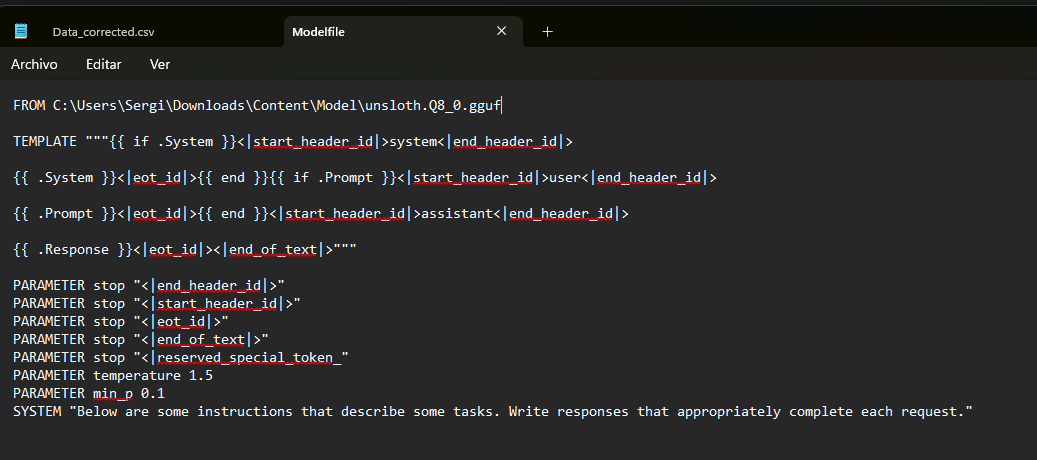


# Ollama

Unsloth ahora permite ajustar el modelo automáticamente y crear un archivo de modelo, exportando a Ollama.

Primero vamos a installar Ollama

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


### Usar ollama

Usamos `subprocess` para iniciar Ollama de forma no bloqueante. En tu propio escritorio, simplemente puedes abrir una nueva terminal y escribir `ollama serve`, pero en Colab, necesitamos usar este truco.

In [ ]:
import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue

### Usar Modelo subido a Hugginface
Si hemos subido el modelo a hugging face podemos descargarlo con el siguiente comando (si el modelo se llama model como este caso, si no habria que sustituir el nombre del modelo por el que sea)
Una vez termine de descargar el modelo hay que parar la ejecucion de la celda para usar el resto del cuaderno

In [ ]:
#!ollama run hf.co/serdom02/model_8bitQ8_0
#!ollama run hf.co/serdom02/model_16bitGGUF
#!ollama run hf.co/serdom02/model_q4_k_mGGUF
!ollama run llama3:8b
#!ollama run hf.co/serdom02/Leyeneitor_8bitQ8_0

^C


Hablar con el modelo de Hugging Face (Solo cambiamos el nombre del modelo)

Hay que detener la celda anterior y volver a iniciar Ollama para poder hablar con el modelo:

In [ ]:
import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue

### Hablar con el modelo usando ollama

Una vez ya tenemos ollama instalado y el modelo descargado podemos interactuar con el modelo usando el siguiente codigo:

In [ ]:
import requests
import json
import re

url = "http://localhost:11434/api/chat"
data = {
    "model": "hf.co/serdom02/Leyeneitor_8bitQ8_0", #Solo cambiamos esta parte
    "messages": [{"role": "user", "content": "El vecino del bloque de enfrente me ha grabado desde su casa y me ha pillado desnudo, creo que lo ha publicado en las redes, puedo denunciar?"}] #Aqui ponemos el mensaje
}

response = requests.post(url, json=data, stream=True)

# Concatenar la respuesta completa y limpiar espacios
full_response = ""
for line in response.iter_lines():
    if line:
        decoded_line = json.loads(line)
        if "message" in decoded_line and "content" in decoded_line["message"]:
            # Limpiar espacios dobles y unir las partes
            full_response += decoded_line["message"]["content"]

# Eliminar saltos de línea y limpiar los espacios extras
full_response = re.sub(r'\s+', ' ', full_response).strip()

print(full_response)

Puedes presentar una denuncia ante la Agencia Española de Protección de Datos (AEPD) o el juez competente por el delito de vulneración de privacidad. Si el vídeo se ha publicado en redes sociales, también puedes ejercer el derecho al olvido solicitando su retirada. En España, grabar a alguien desnudo en su propia casa sin su consentimiento es una violación grave de la privacidad, incluso si ocurre en un lugar público como un balcón. Si la grabación se ha difundido y perjudica tu reputación o intimidad, puedes exigir que la eliminen inmediatamente. Si no estabas al tanto de la grabación y no hay prueba de que consentiste, es probable que sea ilegal. En este caso, podrías presentar una denuncia ante la policía por el delito de vulneración de privacidad, ya que se ha afectado a tus derechos fundamentales. Para protegerte aún más, considera cambiar las contraseñas de tus redes sociales y revisar cualquier publicación tuya que pueda estar relacionada con este incidente.


Si ollama se queda congelado podemos usar kill para matar el proceso

In [ ]:
#Para resetear ollama
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')

# Rag con Llama 3

Fuente: https://medium.com/@danushidk507/rag-with-llama-using-ollama-a-deep-dive-into-retrieval-augmented-generation-c58b9a1cfcd3

In [ ]:
!pip install -U langchain langchain-huggingface transformers
!pip install -U langchain-ollama
!pip install sentence-transformers
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
!pip install -qU langchain-community faiss-cpu
from langchain.vectorstores import FAISS
#print(faiss.__version__)

## Ingesta de Datos
Comenzamos cargando y dividiendo los documentos. Utilizamos PyPDFLoader para cargar un archivo PDF y dividirlo en fragmentos más pequeños y superpuestos, lo que mejora la precisión de la recuperación de información.

In [ ]:
from langchain.document_loaders import PyPDFLoader
#from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Lista de rutas de los PDFs
pdf_paths = [
    "BOE-A-1978-31229-consolidado.pdf",
    "BOE-A-1995-25444-consolidado_CodigoPenal.pdf",
    "Protección de Datos Personales y garantia de los derechos digitales.pdf",
    "RGPD_boe.pdf"
]

# Cargar documentos de todos los PDFs
documents = []
for path in pdf_paths:
    try:
        loader = PyPDFLoader(path)
        documents.extend(loader.load())
    except Exception as e:
        print(f"Error cargando {path}: {e}")

for doc in documents:
    doc.page_content = doc.page_content.replace('\r\n', '\n').replace('\n\n', '\n').strip()


# Dividir los documentos en fragmentos
#text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=30, separator="\n")
#docs = text_splitter.split_documents(documents=documents)

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=800,
    chunk_overlap=200,
    separators=["\n\n\n", "\n\n", "\n", ".", " ", ""],
    tokenizer_name="cl100k_base"  # Compatible con modelos más modernos
)


docs = text_splitter.split_documents(documents=documents)

## Embeddings de Datos y Almacenamiento con FAISS

FAISS (Facebook AI Similarity Search) es una biblioteca versátil y eficiente para la búsqueda de similitudes en vectores. Permite la recuperación escalable y rápida de embeddings.
Elección del Modelo de Embedding

Utilizamos sentence-transformers/all-mpnet-base-v2, conocido por su rendimiento robusto en diversas tareas de procesamiento de texto. Alternativas como BGE o MiniLM pueden ser utilizadas para equilibrar la velocidad y la precisión según el caso específico.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import faiss

# Load embedding model
#embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
embedding_model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
#model_kwargs = {"device": "cuda"}
model_kwargs = {"device": "cpu"}

embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs=model_kwargs
)

# Create FAISS vector store
vectorstore = FAISS.from_documents(docs, embeddings)

# Save and reload the vector store
vectorstore.save_local("faiss_index_")
persisted_vectorstore = FAISS.load_local("faiss_index_", embeddings, allow_dangerous_deserialization=True)

# Create a retriever
retriever = persisted_vectorstore.as_retriever()

print(f"Se indexaron {len(docs)} fragmentos.")

## Seleccionamos el modelo

Aqui podemos probar como responde el modelo sin RAG

In [ ]:
from langchain_ollama import OllamaLLM

# Initialize the LLaMA model
llm = OllamaLLM(model="hf.co/serdom02/Leyeneitor_8bitQ8_0", base_url="http://127.0.0.1:11434") #aqui ponemos el modelo finetuneado

# Test with a sample prompt
response = llm.invoke("Un cuento sobre proteccion de datos")
print(response)

**"La web de la seguridad"**

María era una estudiante que había creado una cuenta en la web de un concurso de programación para practicar sus habilidades. Sin embargo, meses después, comenzó a recibir publicidad en su correo electrónico sobre productos financieros que nunca había solicitado. Al investigar, descubrió que el concurso había compartido sus datos personales con empresas de marketing sin informarle previamente.

María decidió ejercer sus derechos y contactó con la organización para reclamar la eliminación de estos datos y solicitar información sobre qué se habían enviado. La respuesta inicial fue evasiva, pero después de insistir, la empresa confirmó que había sufrido una filtración de datos y que algunos registros habían sido compartidos con terceros sin el consentimiento explícito del participante.

Este incidente le recordó la importancia de leer los términos y condiciones antes de registrarse en cualquier web. Además, se aseguró de cambiar sus credenciales y desactivar 

## Ahora podemos interactuar con el modelo

In [ ]:
import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue

In [ ]:
# Importación correcta para versiones recientes de Langchain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import torch

# --- 1. Separación de roles con ChatPromptTemplate ---
system_prompt = """
Eres un experto legal en protección de datos en España.
Tu tarea es analizar la legalidad de las situaciones planteadas por el usuario.
La respuesta debe ser clara, rigurosa y formal, como si fuera escrita por un profesional del derecho.
No hagas suposiciones. No generalices. No repitas ideas.
"""

user_prompt = """
Fragmentos recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

A continuación, presenta el análisis legal y la conclusión en tres partes:
1. **Introducción breve** del problema legal.
2. **Análisis jurídico** apoyado en los fragmentos recuperados, citando tus fuentes.
3. **Conclusión clara**, con un juicio legal concreto.
"""

chat_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template(user_prompt)
])

# --- 2. Crear la cadena usando load_qa_chain con el prompt de chat ---
chain = load_qa_chain(llm, chain_type="stuff", prompt=chat_prompt)

print("-"*50)
print("Asistente legal de protección de datos listo (usando load_qa_chain con prompt separado). Escribe 'Exit' para salir.")
print("-"*50)

# --- 3. Bucle de Consulta Interactivo ---
while True:
    query = input("\nPregunta: ")
    if query.lower() == "exit":
        break
    if not query.strip():
        continue

    try:
        retriever.search_kwargs = {'k': 5}
        docs_retrieved = retriever.invoke(query)

        input_data = {
            "input_documents": docs_retrieved,
            "question": query
        }

        result = chain.invoke(input_data)

        if isinstance(result, dict) and 'output_text' in result:
            print("\nRespuesta:")
            print(result['output_text'])
        elif isinstance(result, str):
            print("\nRespuesta:")
            print(result)
        else:
            print("\nRespuesta recibida (formato inesperado):")
            print(result)

        print("\nFuentes Recuperadas:")
        for i, doc in enumerate(docs_retrieved):
            source = doc.metadata.get('source', 'N/A')
            page = doc.metadata.get('page', 'N/A')
            print(f"  [{i+1}] Fuente: {source}, Página: {page}")
            print(f"     Fragmento: {doc.page_content[:150]}...")

    except Exception as e:
        print(f"\nError durante la ejecución de la cadena: {e}")

print("\nSaliendo del asistente.")


C:\Users\sdominguez\AppData\Local\Temp\ipykernel_17028\10883580.py:34: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/docs/how_to/#qa-with-rag
  chain = load_qa_chain(llm, chain_type="stuff", prompt=chat_prompt)


--------------------------------------------------
Asistente legal de protección de datos listo (usando load_qa_chain con prompt separado). Escribe 'Exit' para salir.
--------------------------------------------------



Pregunta:  Hola me llamo sergio



Respuesta:
**Problema:** Un colegio desea enviar notificaciones a padres y alumnos mediante una plataforma de mensajería móvil, almacenando datos personales y actividades de los usuarios.

**Análisis:** La normativa española exige que el tratamiento de datos en esta plataforma cumpla con el principio de minimización. Para cumplir con este requisito, la escuela debe informar claramente a los padres y alumnos sobre qué información se almacena, con quién se comparte y para qué finalidad. Además, debe ofrecer la posibilidad de ejercer los derechos de acceso, rectificación o supresión de estos datos.

**Conclusión:** El colegio debe informar de forma clara y transparente sobre el tratamiento de datos personales en la plataforma de mensajería móvil, obteniendo el consentimiento adecuado para su uso.

Fuentes Recuperadas:
  [1] Fuente: BOE-A-1995-25444-consolidado_CodigoPenal.pdf, Página: 93
     Fragmento: comunicación interior con él, y con el cual formen una unidad física.
BOLETÍN OFICIAL

KeyboardInterrupt: Interrupted by user

Plantillas para Propmt Template:

**Plantilla1 Muy restrictiva, se centra en usar solo datos sacados del RAG:**


In [ ]:
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote ÚNICA y EXCLUSIVAMENTE en los siguientes 'Textos Legales Recuperados'.
NO uses ningún conocimiento externo. Si la información en los textos no es suficiente para dar una respuesta fundada, indícalo claramente.
Justifica tu respuesta paso a paso, haciendo referencia explícita a los artículos o secciones relevantes de los textos proporcionados si es posible.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión (Basado SÓLO en los textos recuperados):
"""

**Plantilla 2 Menos restrictiva, permite al modelo usar sus conocimientos adquiridos del finetunning y razonar un poco fuera de los contenidos del RAG**

In [ ]:
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote **principalmente** en los siguientes 'Textos Legales Recuperados'.
Si los textos recuperados contienen suficiente información, responde únicamente basándote en ellos.
Si los textos no contienen una respuesta clara pero la pregunta se refiere a conceptos básicos del RGPD, usa lo aprendido en el entrenamiento para dar una respuesta general, especificando que no proviene de los textos recuperados.
Si la pregunta requiere información específica que no está en los textos recuperados ni en tu entrenamiento, indícalo claramente.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión:
"""

## Clasificación de consultas

El Problema de la función anterior es que si el usuario intenta interactuar con el modelo para temas no legales, por ejemplo, saludar, al incluir los resultados del RAG en el propmt el modelo siempre va a intentar responder usando el contexto legal que recibe del RAG, por ejemplo:



> Pregunta: Hola me llamo sergio

> Respuesta:
"La pregunta plantea si el usuario puede solicitar a una empresa que elimine sus datos personales,
aunque la normativa oblige a conservarlos. Como experto en protección de datos,
debes explicar que solo se pueden conservar los datos estrictamente necesarios para cumplir con obligaciones legales,
y que el usuario debe ser informado sobre el plazo de conservación."



Para solucionar esto hay que analizar la entrada del usuario para verificar si es una consulta legal que necesite de RAG o simplemente esta interactuando con el modelo.

In [ ]:
llm_evaluador = OllamaLLM(model="llama3:8b",base_url="http://127.0.0.1:11434") #aqui ponemos el modelo finetuneado

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain  # Necesario para la clasificación
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import torch

# --- 1. Función de Clasificación de Intención (Modelo de Clasificación Separado) ---
def classify_intent_with_classifier(query, llm_evaluador):
    """Clasifica si se necesita usar RAG para generar la respuesta."""
    classification_prompt_template = """
    Analiza la siguiente pregunta del usuario. Determina si la pregunta requiere un análisis legal sobre protección de datos en España (como RGPD, LOPDGDD) o si se puede responder sin el uso de RAG, es decir, si el modelo tiene suficiente conocimiento para dar una respuesta sin fragmentos adicionales.

    Responde únicamente con la palabra "USAR_RAG" si la pregunta requiere fragmentos recuperados para una respuesta precisa.
    Responde únicamente con la palabra "NO_RAG" si la pregunta no requiere fragmentos adicionales y puede ser respondida directamente con el conocimiento general del modelo.

    Pregunta del usuario: "{user_query}"

    Clasificación (USAR_RAG o NO_RAG):"""

    prompt = PromptTemplate(template=classification_prompt_template, input_variables=["user_query"])

    classification_runnable = prompt | llm_evaluador

    try:
        result = classification_runnable.invoke({"user_query": query})

        # Extraer texto. Ajusta la clave ('text') si tu LLM devuelve otra cosa.
        if isinstance(result, dict):
            answer_text = result.get('text', '').strip().upper()
        elif isinstance(result, str):
            answer_text = result.strip().upper()
        else:
            answer_text = str(result).strip().upper()

        # Debug de la clasificación
        print(f"--- DEBUG: Clasificación LLM respondió: '{answer_text}' ---")

        if "USAR_RAG" in answer_text:
            return "USAR_RAG"
        elif "NO_RAG" in answer_text:
            return "NO_RAG"
        else:
            print("--- WARN: Respuesta de clasificación no clara, asumiendo NO_RAG por seguridad ---")
            return "NO_RAG"  # Default seguro

    except Exception as e:
        print(f"Error en la clasificación de intención con LLM: {e}")
        return "USAR_RAG"  # Default seguro en caso de error

# --- 2. Definiciones para el prompt de RAG ---
system_prompt_rag = """
Eres un experto legal en protección de datos en España.
Tu tarea es analizar la legalidad de las situaciones planteadas por el usuario utilizando fragmentos recuperados.
La respuesta debe ser clara, rigurosa y formal, como si fuera escrita por un profesional del derecho.
No hagas suposiciones. No generalices. No repitas ideas.
"""

user_prompt_rag = """
Fragmentos recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

A continuación, presenta el análisis legal y la conclusión en tres partes:
1. **Introducción breve** del problema legal.
2. **Análisis jurídico** apoyado en los fragmentos recuperados, citando tus fuentes.
3. **Conclusión clara**, con un juicio legal concreto.
"""

chat_prompt_rag = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt_rag),
    HumanMessagePromptTemplate.from_template(user_prompt_rag)
])

# --- 3. Definiciones para la respuesta conversacional ---
conversational_prompt_template = """
Ya no eres un asistente legal, ahora eres un asistente de IA amigable y conversador. Responde directamente al usuario de forma natural.
Usuario: {user_input}
Asistente:"""
PROMPT_CONVERSATIONAL = PromptTemplate(template=conversational_prompt_template, input_variables=["user_input"])

# --- 4. Crear la cadena usando load_qa_chain para el modelo de RAG ---
chain_rag = load_qa_chain(llm, chain_type="stuff", prompt=chat_prompt_rag)

# --- 5. Bucle de Consulta Interactivo ---

print("-"*50)
print("Asistente listo. Escribe 'Exit' para salir.")
print("-"*50)

while True:
    query = input("\nPregunta: ")
    if query.lower() == "exit":
        break
    if not query.strip():
        continue

    # --- Paso 1: Clasificar la intención del usuario ---
    intent = classify_intent_with_classifier(query, llm_evaluador)
    print(f"--- Intención Detectada: {intent} ---")

    # --- Ejecutar flujo según la intención ---
    if intent == "USAR_RAG":
        print("--- Ejecutando RAG para consulta legal ---")
        try:
            # 1. Recuperar documentos (RAG)
            retriever.search_kwargs = {'k': 3}  # Ajusta 'k' si es necesario
            docs_retrieved = retriever.invoke(query)

            # 2. Preparar input para la cadena RAG
            input_data = {
                "input_documents": docs_retrieved,
                "question": query
            }

            # 3. Ejecutar la cadena RAG
            result = chain_rag.invoke(input_data)

            # 4. Imprimir resultado RAG
            if isinstance(result, dict) and 'output_text' in result:
                print("\nRespuesta (Legal):")
                print(result['output_text'])
            elif isinstance(result, str):
                print("\nRespuesta (Legal):")
                print(result)
            else:
                print("\nRespuesta RAG recibida (formato inesperado):")
                print(result)

            # 5. Imprimir fuentes (Opcional)
            print("\nFuentes Recuperadas:")
            for i, doc in enumerate(docs_retrieved):
                source = doc.metadata.get('source', 'N/A')
                page = doc.metadata.get('page', 'N/A')
                print(f"  [{i+1}] Fuente: {source}, Página: {page}")
                print(f"     Fragmento: {doc.page_content[:150]}...")

        except Exception as e:
            print(f"\nError durante la ejecución de la cadena RAG: {e}")

    elif intent == "NO_RAG":
        print("--- Generando respuesta sin usar RAG ---")
        try:
            # 1. Formatear prompt conversacional simple
            simple_prompt = PROMPT_CONVERSATIONAL.format(user_input=query)

            # 2. Llamar directamente al LLM (sin RAG)
            response = llm.invoke(simple_prompt)

            # 3. Extraer y limpiar la respuesta
            if isinstance(response, dict):
                 # Adapta la clave si 'invoke' devuelve un dict con otra clave para el texto
                 response_text = response.get('text', str(response))
            elif isinstance(response, str):
                 response_text = response
            else:
                 response_text = str(response)

            # Limpieza: quitar el prompt si el LLM lo repite
            print("\nRespuesta (Conversacional):")
            print(response_text)

        except Exception as e:
            print(f"\nError durante la llamada conversacional al LLM: {e}")
    else:
        print(f"--- ERROR: Intención desconocida '{intent}' recibida de la clasificación ---")

print("\nSaliendo del asistente.")


C:\Users\sdominguez\AppData\Local\Temp\ipykernel_9964\334576307.py:87: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/docs/how_to/#qa-with-rag
  chain_rag = load_qa_chain(llm, chain_type="stuff", prompt=chat_prompt_rag)


--------------------------------------------------
Asistente listo. Escribe 'Exit' para salir.
--------------------------------------------------


KeyboardInterrupt: Interrupted by user

Vemos que ahora si le decimos algo que no es claramente algo relacionado con temas legales, como "Hola me llamo Sergio" se detecta que es una conversación normal y no se activa el RAG:


> Pregunta: Hola me llamo sergio


> Respuesta (Conversacional):
Hola Sergio, ¿en qué puedo ayudarte hoy?

¿Pero que pasa si hacemos una pregunta legal y luego seguimos intentando consultar al modelo sobre la pregunta inicial?



> Pregunta:  Tengo una consulta sobre protección de datos, mi gimnasio me pide mi huella dactilar para poder entrar al gimnasio, ¿pueden exirgirmelo?


> Respuesta (Legal):
**Introducción**: Un gimnasio quiere usar datos biométricos (como la huella dactilar) para controlar el acceso a sus instalaciones. Este tratamiento de datos personales requiere una base legal clara y garantías de seguridad adecuadas.
**Análisis**: El uso de datos biométricos para fines como el control de acceso debe basarse en un principio de consentimiento explícito, salvo que exista una justificación legal específica (como la seguridad pública). En este caso, se deben aplicar medidas adicionales para proteger estos datos sensibles, ya que permiten identificar de forma única a cada persona. Además, el gimnasio debe informar claramente sobre el propósito del tratamiento y las garantías de seguridad adoptadas.
**Conclusión**: Para que este tratamiento sea lícito, debe existir una base legal clara (como el consentimiento informado o una obligación legal) y se deben aplicar medidas adecuadas para proteger estos datos sensibles.



> Pregunta: ¿Puedo negarme?


> Respuesta (Legal):
Una empresa farmacéutica me ha solicitado información personal para estudiar la eficacia de un medicamento, pero prefiero no participar. ¿Tengo derecho a negarme?
Análisis legal: Por ser un estudio clínico, se requiere tu consentimiento explícito. Si no das tu autorización, no pueden procesar tus datos. Sin embargo, si la investigación tiene relevancia para el bienestar público o hay una obligación legal, podrían excepcionalmente utilizar los datos anónimos o con medidas de protección específicas.
Conclusión: Tienes derecho a negarte si el estudio clínico no cumple con tus derechos y garantías de privacidad.



---

Podemos observar que el modelo al activarse el RAG pierde el contexto de la pregunta anterior y responde algo totalmente diferente, seguramente debido a que RAG ha recuperado textos donde se incluya "¿puedo negarme?" que no estan relacionados con el contexto anterior, por lo que se inyecta contexto erroneo en el propmt.





## Memoria Conversacional con RAG

Para solucionar el problema de continuidad del contexto en la conversación vamos a añadir memoria al RAG, para ello, LangChain tiene una variedad de herramientas que permite implementarlo

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain  # Necesario para la clasificación
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import torch

# Añadimos una clase de memoria conversacional
class ConversationMemory:
    def __init__(self, max_turns=10):
        self.max_turns = max_turns
        self.history = []

    def add_turn(self, user_input, assistant_response):
        self.history.append((user_input, assistant_response))
        if len(self.history) > self.max_turns:
            self.history.pop(0)

    def get_memory_as_text(self):
        return "\n".join([f"Usuario: {u}\nAsistente: {a}" for u, a in self.history])

# --- 1. Función de Clasificación de Intención (Modelo de Clasificación Separado) ---
def classify_intent_with_classifier(query, llm_evaluador):
    """Clasifica si se necesita usar RAG para generar la respuesta."""
    classification_prompt_template = """
        Analiza la siguiente consulta del usuario. Decide si es necesario usar RAG (fragmentos legales recuperados) o si el modelo puede responder directamente.

        Solo debes responder con:
        - "USAR_RAG" → si se requiere un análisis legal riguroso, citas precisas o fundamentación jurídica específica.
        - "NO_RAG" → si el modelo puede dar una respuesta general, introductoria o basada en conocimiento común sin necesidad de fragmentos legales.

        Ejemplos:
        - Pregunta: "¿Puede una empresa ceder mis datos sin consentimiento?" → NO_RAG
        - Pregunta: "¿Qué dice el artículo 6 del RGPD sobre el consentimiento?" → USAR_RAG
        - Pregunta: "¿Puedes citar el artículo 13 del RGPD?" → USAR_RAG
        - Pregunta: "¿En qué artículo se regula el consentimiento explícito?" → USAR_RAG
        - Pregunta: "Puedes decirme en qué artículos te basas?" → USAR_RAG
        - Pregunta: "Cita textualmente en qué artículos te basas" → USAR_RAG
        - Pregunta: "¿Qué derechos tengo como interesado?" → NO_RAG
        - Pregunta: "¿Cómo elimino mis datos personales?" → NO_RAG


        Pregunta del usuario: "{user_query}"

        Clasificación (USAR_RAG o NO_RAG):"""

    prompt = PromptTemplate(template=classification_prompt_template, input_variables=["user_query"])

    classification_runnable = prompt | llm_evaluador

    try:
        result = classification_runnable.invoke({"user_query": query})

        # Extraer texto. Ajusta la clave ('text') si tu LLM devuelve otra cosa.
        if isinstance(result, dict):
            answer_text = result.get('text', '').strip().upper()
        elif isinstance(result, str):
            answer_text = result.strip().upper()
        else:
            answer_text = str(result).strip().upper()

        # Debug de la clasificación
        print(f"--- DEBUG: Clasificación LLM respondió: '{answer_text}' ---")

        if "USAR_RAG" in answer_text.upper():
            return "USAR_RAG"
        elif "NO_RAG" in answer_text:
            return "NO_RAG"
        else:
            print("--- WARN: Respuesta de clasificación no clara, asumiendo NO_RAG por seguridad ---")
            return "NO_RAG"  # Default seguro

    except Exception as e:
        print(f"Error en la clasificación de intención con LLM: {e}")
        return "USAR_RAG"  # Default seguro en caso de error

# --- 2. Definiciones para el prompt de RAG ---
system_prompt_rag = """
Eres un experto legal en protección de datos en España.
Tu tarea es analizar la legalidad de las situaciones planteadas por el usuario utilizando fragmentos recuperados.
La respuesta debe ser clara, rigurosa y formal, como si fuera escrita por un profesional del derecho.
No hagas suposiciones. No generalices. No repitas ideas.
"""

user_prompt_rag = """
Fragmentos recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

A continuación, presenta el análisis legal y la conclusión en tres partes:
1. **Introducción breve** del problema legal.
2. **Análisis jurídico** apoyado en los fragmentos recuperados, citando tus fuentes.
3. **Conclusión clara**, con un juicio legal concreto.
"""

chat_prompt_rag = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt_rag),
    HumanMessagePromptTemplate.from_template(user_prompt_rag)
])

# --- 3. Definiciones para la respuesta conversacional ---
conversational_prompt_template = """
Eres un asistente de IA amigable y conversador. Tu tarea es mantener una conversación fluida y coherente con el usuario.
Responde de forma natural y cercana, teniendo en cuenta lo que ya se ha dicho.

Historial reciente de la conversación:
{chat_history}

Usuario: {user_input}
Asistente:"""

PROMPT_CONVERSATIONAL = PromptTemplate(
    template=conversational_prompt_template,
    input_variables=["chat_history", "user_input"]
)

# --- 4. Crear la cadena usando load_qa_chain para el modelo de RAG ---
chain_rag = load_qa_chain(llm, chain_type="stuff", prompt=chat_prompt_rag)

# --- 5. Bucle de Consulta Interactivo ---

print("-"*50)
print("Asistente listo. Escribe 'Exit' para salir.")
print("-"*50)
memory = ConversationMemory(max_turns=6)

while True:
    query = input("\nPregunta: ")
    if query.lower() == "exit":
        break
    if not query.strip():
        continue

    intent = classify_intent_with_classifier(query, llm_evaluador)
    print(f"--- Intención Detectada: {intent} ---")

    if intent == "USAR_RAG":
        print("--- Ejecutando RAG para consulta legal ---")
        try:
            retriever.search_kwargs = {'k': 3}
            docs_retrieved = retriever.invoke(query)

            input_data = {
                "input_documents": docs_retrieved,
                "question": query
            }

            result = chain_rag.invoke(input_data)
            response_text = result.get('output_text', result if isinstance(result, str) else str(result))

            print("\nRespuesta (Legal):")
            print(response_text)

            memory.add_turn(query, response_text)

            print("\nFuentes Recuperadas:")
            for i, doc in enumerate(docs_retrieved):
                source = doc.metadata.get('source', 'N/A')
                page = doc.metadata.get('page', 'N/A')
                print(f"  [{i+1}] Fuente: {source}, Página: {page}")
                print(f"     Fragmento: {doc.page_content[:150]}...")

        except Exception as e:
            print(f"\nError durante la ejecución de la cadena RAG: {e}")

    elif intent == "NO_RAG":
        print("--- Generando respuesta sin usar RAG ---")
        try:
            prompt_with_memory = PROMPT_CONVERSATIONAL.format(
                chat_history=memory.get_memory_as_text(),
                user_input=query
            )

            response = llm.invoke(prompt_with_memory)

            if isinstance(response, dict):
                response_text = response.get('text', str(response))
            elif isinstance(response, str):
                response_text = response
            else:
                response_text = str(response)

            if "Asistente:" in response_text:
                response_text = response_text.split("Asistente:", 1)[-1].strip()

            print("\nRespuesta (Conversacional):")
            print(response_text)

            memory.add_turn(query, response_text)

        except Exception as e:
            print(f"\nError durante la llamada conversacional al LLM: {e}")
    else:
        print(f"--- ERROR: Intención desconocida '{intent}' recibida de la clasificación ---")

print("\nSaliendo del asistente.")



--------------------------------------------------
Asistente listo. Escribe 'Exit' para salir.
--------------------------------------------------



Pregunta:  Hola me llamo sergio


2025-05-08 11:42:53,890 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


--- DEBUG: Clasificación LLM respondió: 'NO_RAG' ---
--- Intención Detectada: NO_RAG ---
--- Generando respuesta sin usar RAG ---


2025-05-08 11:43:00,024 - asyncio - ERROR - Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at C:\ProgramData\anaconda3\Lib\site-packages\uvicorn\server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\uvicorn\main.py", line 580, in run
    server.run()
  File "C:\ProgramData\anaconda3\Lib\site-packages\uvicorn\server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "C:\ProgramData\anaconda3\Lib\site-packages\nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "C:\ProgramData\

KeyboardInterrupt: 

# APLICACION FINAL MEJORADA

In [ ]:
!pip install -U langchain langchain-huggingface transformers
!pip install -U langchain-ollama
!pip install sentence-transformers
!pip install pypdf
!pip install -qU langchain-community faiss-cpu
!pip install -U scikit-learn
!pip install tiktoken
import logging
from langchain.vectorstores import FAISS

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("asistente_legal.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("asistente_legal")
logger.info("Iniciando asistente legal de protección de datos")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2025-05-08 14:59:06,685 - asistente_legal - INFO - Iniciando asistente legal de protección de datos


In [ ]:
# Celda 2: Carga y procesamiento de documentos mejorado
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import re
import tiktoken
from transformers import AutoTokenizer

# Lista de rutas de los PDFs
pdf_paths = [
    "BOE-A-1978-31229-consolidado.pdf",
    "BOE-A-1995-25444-consolidado_CodigoPenal.pdf",
    "Protección de Datos Personales y garantia de los derechos digitales.pdf",
    "RGPD_boe.pdf"
]

# Función para identificar tipo de documento y mejorar metadatos
def enrich_metadata(doc):
    filename = doc.metadata.get('source', '')

    # Añadir información sobre tipo de documento
    if "RGPD" in filename:
        doc.metadata['tipo'] = 'RGPD'
        doc.metadata['jerarquia'] = 'Reglamento Europeo'
    elif "BOE-A-1978" in filename:
        doc.metadata['tipo'] = 'Constitución'
        doc.metadata['jerarquia'] = 'Constitución Española'
    elif "BOE-A-1995" in filename:
        doc.metadata['tipo'] = 'Código Penal'
        doc.metadata['jerarquia'] = 'Ley Orgánica'
    elif "Protección de Datos" in filename:
        doc.metadata['tipo'] = 'LOPDGDD'
        doc.metadata['jerarquia'] = 'Ley Orgánica'

    # Extraer información de artículos si está disponible
    article_match = re.search(r'Artículo (\d+)', doc.page_content)
    if article_match:
        doc.metadata['tipo_contenido'] = 'artículo'
        doc.metadata['num_articulo'] = article_match.group(1)

    return doc

# Cargar documentos de todos los PDFs con manejo de errores
documents = []
for path in pdf_paths:
    try:
        logger.info(f"Cargando documento: {path}")
        loader = PyPDFLoader(path)
        documents.extend(loader.load())
    except Exception as e:
        logger.error(f"Error cargando {path}: {e}")

# Limpiar y normalizar contenido
for doc in documents:
    doc.page_content = doc.page_content.replace('\r\n', '\n').replace('\n\n', '\n').strip()
    doc = enrich_metadata(doc)

logger.info(f"Documentos cargados: {len(documents)}")

# Splitter optimizado para textos legales
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=800,  # Tamaño optimizado para capturar contexto legal completo
    chunk_overlap=200,  # Mayor overlap para mantener coherencia
    separators=["\n\n\n", "\n\n", "\n", ".", " ", ""],
    encoding_name="cl100k_base"  # Compatible con modelos modernos
)

docs = text_splitter.split_documents(documents=documents)
logger.info(f"Documentos divididos en {len(docs)} fragmentos")

2025-05-08 14:59:12,976 - numexpr.utils - INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-08 14:59:12,978 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2025-05-08 14:59:13,919 - asistente_legal - INFO - Cargando documento: BOE-A-1978-31229-consolidado.pdf
2025-05-08 14:59:14,826 - asistente_legal - INFO - Cargando documento: BOE-A-1995-25444-consolidado_CodigoPenal.pdf
2025-05-08 14:59:18,609 - asistente_legal - INFO - Cargando documento: Protección de Datos Personales y garantia de los derechos digitales.pdf
2025-05-08 14:59:19,780 - asistente_legal - INFO - Cargando documento: RGPD_boe.pdf
2025-05-08 14:59:22,168 - asistente_legal - INFO - Documentos cargados: 404
2025-05-08 14:59:23,325 - asistente_legal - INFO - Documentos divididos en 798 fragmentos


In [ ]:
# Celda 3: Embeddings mejorados y sistema de recuperación
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# Configuración de embeddings para español y textos jurídicos
embedding_model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {"device": "cpu"}

embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs=model_kwargs
)

# Crear vector store
logger.info("Creando índice vectorial FAISS")
vectorstore = FAISS.from_documents(docs, embeddings)

# Guardar y recargar el vector store
vectorstore.save_local("faiss_index_")
persisted_vectorstore = FAISS.load_local("faiss_index_", embeddings, allow_dangerous_deserialization=True)

# Crear retriever base con MMR para diversidad de resultados
base_retriever = persisted_vectorstore.as_retriever(
    search_type="mmr",  # Maximum Marginal Relevance para diversidad
    search_kwargs={
        "k": 5,  # Recuperar más documentos inicialmente
        "fetch_k": 10,  # Considerar más candidatos
        "lambda_mult": 0.7  # Balance entre relevancia y diversidad
    }
)

logger.info(f"Se indexaron {len(docs)} fragmentos")

2025-05-08 14:59:26,985 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2025-05-08 14:59:29,788 - asistente_legal - INFO - Creando índice vectorial FAISS
2025-05-08 14:59:41,540 - faiss.loader - INFO - Loading faiss with AVX512 support.
2025-05-08 14:59:41,541 - faiss.loader - INFO - Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
2025-05-08 14:59:41,541 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-05-08 14:59:41,808 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-05-08 14:59:41,817 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-05-08 14:59:41,917 - asistente_legal - INFO - Se indexaron 798 fragmentos


In [ ]:
# Celda 4: Configuración del modelo LLM
from langchain_ollama import OllamaLLM
import time

# Inicializar el modelo LLaMA con timeout
llm_legal = OllamaLLM(
    model="hf.co/serdom02/Leyeneitor_8bitQ8_0",
    base_url="http://127.0.0.1:11434",
    temperature=0.3,  # Menor temperatura para respuestas legales más precisas
    timeout=60  # Timeout de 60 segundos para evitar bloqueos
)
llm_conversacion = OllamaLLM(
    model="llama3:8b",
    base_url="http://127.0.0.1:11434",
    temperature=0.6, # temperatura más alta para conversación
    timeout=60
)
# Inicializar un modelo para evaluación/clasificación (puede ser el mismo)
llm_evaluador = llm_conversacion

llm=llm_legal #El modelo principal va a ser nuestro LLM Finetuneado

# Test rápido del modelo
try:
    response = llm_legal.invoke("Un breve ejemplo sobre protección de datos")
    print("Test del modelo exitoso:")
    print(response)
except Exception as e:
    logger.error(f"Error al probar el modelo: {e}")


2025-05-08 14:59:48,623 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Test del modelo exitoso:
**Ejemplo: Una clínica dental utiliza un servicio en la nube para almacenar historiales médicos, pero no informa a los pacientes sobre cómo se protegen sus datos.**

**Problema:** La clínica no está cumpliendo con la normativa de protección de datos, ya que no informa sobre el tratamiento de los datos ni toma medidas de seguridad adecuadas para un servicio en la nube.

**Solución:** La clínica debe informar a los pacientes sobre cómo se almacenan y protegen sus datos en la nube, incluyendo quién es el responsable del tratamiento. Además, debe implementar medidas de seguridad como cifrado y acceso restringido para garantizar la integridad de los historiales médicos.


In [ ]:
# --- 7. Prompts mejorados según tipología de consulta ---

# Prompt base/genérico (fallback)
system_prompt_rag = """
Sistema: Eres un asistente legal especializado en protección de datos en España (RGPD y LOPDGDD). Tu objetivo es proporcionar respuestas claras, precisas y fundamentadas en la ley.

Contexto legal relevante extraído de la documentación:
---------------------
{context}
---------------------

Consulta del usuario: {question}

Instrucciones:
1. Basa tu respuesta EXCLUSIVAMENTE en el contexto legal proporcionado arriba.
2. Si el contexto no es suficiente para responder, indica que la información no se encuentra en los documentos proporcionados.
3. Responde de forma directa y estructurada a la consulta del usuario.
4. Cita las fuentes (ej. "Según el Artículo X del RGPD...") si es posible basándote en el contexto.
5. Evita dar opiniones personales o información no verificada.
"""

# Prompt para citas legales
legal_citation_prompt = """
Sistema: Eres un asistente jurídico experto en el Reglamento General de Protección de Datos (RGPD). Tu tarea es citar artículos legales de forma textual y precisa cuando el usuario lo solicita.

---------------------
Documentos disponibles:
{context}
---------------------

Consulta del usuario:
{question}

Instrucciones:
1. Extrae **todos los artículos del RGPD** que traten sobre el tema mencionado en la consulta.
2. Para cada artículo encontrado, incluye:
   - El número del artículo (ej. Artículo 6 del RGPD)
   - El **texto literal más relevante** (puede ser un apartado si es muy largo)
   - La **fuente** (ej. “Fuente: RGPD, pág. 12”)
3. Usa este formato:
   Artículo X del RGPD:
   “Texto legal...”
   Fuente: RGPD, pág. X

4. Si hay varios artículos relevantes, enuméralos claramente.
5. No inventes. Si el texto literal no está en el contexto, indícalo explícitamente.
6. No incluyas artículos de otras leyes (como LOPDGDD o Constitución) salvo que se mencione expresamente.

Ejemplo:
Artículo 6.1 del RGPD:
“El tratamiento será lícito solo si se cumple al menos una de las siguientes condiciones: [...]”
Fuente: RGPD, pág. 8
"""

legal_multi_citation_prompt = """
Eres un asistente jurídico experto en el RGPD. El usuario solicita una lista de artículos relacionados con un tema específico.

Instrucciones:
1. Identifica todos los artículos del RGPD que se relacionen con el tema de la consulta.
2. Si el artículo aparece en el contexto, cita su número y el **texto literal completo** relevante.
3. Si no aparece el texto completo, menciona el número del artículo y una breve descripción basada en el título o lo que sepas del RGPD.
4. No inventes textos. Si hay dudas, di que no tienes acceso al contenido exacto.
5. Formatea la respuesta como una lista clara y numerada.

Consulta: {question}
Fragmentos del RGPD disponibles:
---------------------
{context}
---------------------
Respuesta:
"""


# Prompt para análisis legal
legal_analysis_prompt = """
Sistema: Eres un jurista experto analizando situaciones bajo la ley de protección de datos española (RGPD, LOPDGDD). Razonas jurídicamente paso a paso.

Contexto legal relevante extraído de la documentación:
---------------------
{context}
---------------------

Consulta del usuario que requiere análisis legal: {question}

Instrucciones para tu análisis:
1. **Identifica la cuestión jurídica principal** planteada en la consulta.
2. **Selecciona las normas aplicables** del contexto legal proporcionado que sean pertinentes para la cuestión.
3. **Analiza los hechos implícitos o explícitos** en la consulta a la luz de las normas seleccionadas.
4. **Aplica las normas a los hechos**, explicando tu razonamiento paso a paso basado únicamente en el contexto proporcionado.
5. **Formula una conclusión jurídica** clara y fundamentada en el análisis anterior y el contexto. Si el contexto es insuficiente, señala las limitaciones.

Estructura tu respuesta:
* **Cuestión planteada:** (Resume la pregunta legal)
* **Normativa aplicable (según contexto):** (Menciona artículos/disposiciones relevantes del contexto)
* **Análisis jurídico:** (Desarrolla tu razonamiento aquí, conectando contexto y consulta)
* **Conclusión:** (Respuesta final basada en el análisis)
"""

# Prompt para consultas procedimentales
procedural_prompt = """
Sistema: Eres un consultor experto en los procedimientos y trámites relacionados con la protección de datos en España (AEPD, derechos ARSULIPO, etc.). Proporcionas información práctica.

Contexto legal relevante extraído de la documentación (puede contener información sobre procedimientos):
---------------------
{context}
---------------------

Consulta del usuario sobre un procedimiento o trámite: {question}

Instrucciones:
1. Identifica claramente el **procedimiento o trámite** consultado.
2. Busca en el contexto información relevante sobre los **pasos a seguir, plazos, requisitos, o autoridad competente**.
3. Explica el procedimiento de forma **clara, secuencial y práctica**, basándote en la información del contexto.
4. Si el contexto menciona la base legal, puedes indicarla brevemente, pero prioriza la **descripción del proceso**.
5. Si la información específica sobre el procedimiento no está en el contexto, indica que no se puede detallar con la documentación disponible. NO inventes pasos o plazos.
"""

# Prompt para información general
general_info_prompt = """
Sistema: Eres un asistente informativo sobre protección de datos. Explicas conceptos generales de forma clara y sencilla.

Contexto legal relevante extraído de la documentación:
---------------------
{context}
---------------------

Consulta general del usuario: {question}

Instrucciones:
1. Identifica el concepto o tema general sobre el que pregunta el usuario.
2. Busca definiciones, explicaciones o principios relevantes en el contexto proporcionado.
3. Explica el concepto de forma clara y concisa, utilizando la información del contexto.
4. Puedes usar ejemplos si el contexto los proporciona o si son derivados directos de la explicación legal.
5. Cita la fuente si es relevante (ej. "El RGPD define X como...").
6. Si la información no está en el contexto, indícalo.
"""

# Prompt para conversación general (cuando no se usa RAG)
conversation_prompt = """
Sistema: Eres un asistente legal amable y conversacional llamado Leyeneitor. Tu especialidad es la protección de datos, PERO ahora estás en modo conversacional. Ignora tu rol legal por un momento y responde directamente a la pregunta o comentario del usuario de forma natural y breve como un asistente general.
NO des respuestas sobre protección de datos o leyes a menos que la pregunta sea específicamente sobre eso. Sé breve y directo.

Historial reciente de la conversación (para contexto):
{memory}
Asistente:"""

action_oriented_prompt = """
Sistema: Eres un asesor jurídico especializado en protección de datos (RGPD, LOPDGDD) y derechos digitales. Tu tarea es explicar de manera clara qué **acciones, derechos o reclamaciones** puede ejercer el usuario en la situación planteada.

Contexto legal relevante extraído de la documentación:
---------------------
{context}
---------------------

Nueva consulta (enfocada en qué puede hacer el usuario): {question}

Instrucciones específicas para tu respuesta:
1. **Identifica los derechos relevantes** (acceso, oposición, supresión, portabilidad, etc.) que el usuario podría ejercer según el contexto.
2. **Describe las acciones prácticas** que puede realizar el usuario, incluyendo:
   - Cómo ejercer su derecho (por ejemplo: “solicitarlo por escrito”, “presentar reclamación ante la AEPD”).
   - Ante quién debe dirigirse (empresa, delegado de protección de datos, AEPD...).
   - Qué requisitos o pasos debe seguir.
3. **Si procede,** menciona los artículos legales que respaldan las acciones propuestas (sin recargar la respuesta).
4. Explica de forma **estructurada y práctica**, usando pasos o listas si facilita la comprensión.
5. Si no hay suficiente información en el contexto para dar un procedimiento concreto, **indícalo claramente**. No inventes.

Estructura sugerida para tu respuesta:
* **Derechos aplicables:** (Enumera los derechos relevantes)
* **Acciones que puede realizar:** (Pasos claros y prácticos)
* **Normativa de respaldo:** (Artículos relevantes, si es aplicable)
* **Notas importantes:** (Advertencias o limitaciones si las hubiera)

Evita explicaciones teóricas largas. Sé claro, útil y orientado a lo que el usuario puede **hacer**.
"""
refinement_module_prompt = """
Eres un jurista experto en derecho de protección de datos.
Tu tarea es **corregir y mejorar** una respuesta legal manteniendo su estructura original.


Basándote en los siguientes fallos identificados por un validador, **ajusta cada sección que lo requiera** para mejorar la precisión y completitud jurídica.
No elimines secciones ni cambies su orden. Si una sección no requiere corrección, déjala intacta.
Si alguno de los fallos detectados se refiere a consentimiento, derechos fundamentales o proporcionalidad, asegúrate de explicarlos de forma técnica y precisa en la sección correspondiente.

--- FALLAS DETECTADAS ---
{fallos}

Es obligatorio que sigas la Estructura de la respuesta original

--- RESPUESTA ORIGINAL ---
{respuesta}

--- INSTRUCCIONES ---
Corrige las secciones necesarias dentro de la estructura, sin añadir otras partes nuevas. Usa lenguaje jurídico claro y fundamentado.
"""

In [ ]:
# Celda 5: Sistema completo con mejoras y correcciones
from langchain.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.chains import LLMChain # Aunque no se usa directamente, puede ser útil
import json
import time
import random
import re
import unicodedata
import logging # Asegúrate de que el logger está configurado
from langchain.chains.question_answering import load_qa_chain

# Obtener el logger configurado en la Celda 1
logger = logging.getLogger("asistente_legal")

# --- 0. Para que cada usuario tenga su memoria ---
class UsuarioSession:
    def __init__(self):
        self.memory = ImprovedMemory(max_turns=4)
        self.last_query = None

# --- 1. Memoria Conversacional Mejorada ---
class ImprovedMemory:
    def __init__(self, max_turns=6):
        self.summary = ""
        self.recent_turns = []
        self.max_turns = max_turns
        self.entities = {}  # Seguimiento de entidades legales

    def get_all_turns(self):
        """Devuelve todos los turnos almacenados en la memoria"""
        return self.recent_turns

    def get_relevant_memory(self, query):
        """Devuelve memoria relevante para la consulta actual"""
        # Versión sencilla: devolver todo el historial
        return self.get_memory_as_text()
        # Versión avanzada (requiere embeddings): pendiente

    def add_turn(self, user_input, assistant_response, llm=None):
        self.recent_turns.append((user_input, assistant_response))

        # Extraer y rastrear entidades legales mencionadas
        self._extract_entities(user_input + " " + assistant_response)

        if len(self.recent_turns) > self.max_turns:
            if llm_evaluador:  # Si tenemos acceso al LLM, generamos resumen, no usamos el modelo finetuneado para evitar sus sesgos legales
                try:
                    # Generar resumen del contexto anterior (turnos más antiguos) para ahorrar espacio del contexto
                    context_to_summarize = "\n".join([f"U: {u}\nA: {a}" for u, a in self.recent_turns[:-self.max_turns]]) # Corregido: resumir los que se van a quitar
                    if context_to_summarize: # Solo si hay algo que resumir
                         prompt = f"Resume brevemente los puntos legales clave de esta conversación anterior:\n{context_to_summarize}"
                         new_summary = llm.invoke(prompt)
                         # Concatenar resumen nuevo con el anterior si existe
                         self.summary = f"{self.summary}\n{new_summary}".strip()
                         logger.info("Resumen de memoria actualizado.")
                except Exception as e:
                    logger.warning(f"Error al generar resumen de memoria: {e}")

            # Mantener solo los turnos más recientes
            self.recent_turns = self.recent_turns[-self.max_turns:]

    def _extract_entities(self, text):
        # Detección simple de entidades legales
        patterns = {
            'articulos': r'art(?:ículo|\.)\s+(\d+)',
            'leyes': r'(?:RGPD|LOPDGDD|Reglamento|Ley Orgánica|Constitución|Código Penal)'
        }

        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, text, re.IGNORECASE)
            for match in matches:
                entity = f"{entity_type}_{match.upper()}" # Normalizar nombre
                self.entities[entity] = self.entities.get(entity, 0) + 1

    def get_memory_as_text(self):
        memory_text = ""
        if self.summary:
            memory_text += f"Resumen de puntos legales anteriores:\n{self.summary}\n\n"

        if self.recent_turns:
             memory_text += "Historial reciente de la conversación:\n"
             memory_text += "\n".join([f"Usuario: {u}\nAsistente: {a}" for u, a in self.recent_turns])

        # Añadir entidades más relevantes si existen
        if self.entities:
            top_entities = sorted(self.entities.items(), key=lambda x: x[1], reverse=True)[:3]
            if top_entities:
                memory_text += "\n\nTemas legales clave mencionados: " + ", ".join([e[0].replace('_', ' ') for e in top_entities])

        return memory_text.strip()

# --- 2. Sistema de Clasificación Avanzado (Versión única y completa) ---
def classify_intent_advanced(query, llm_evaluador):

    """Sistema de clasificación avanzado con múltiples categorías y confianza"""
    #Sistema cache para no reclasificar preguntas parecidas
    cache_key = ' '.join(query.lower().split()[:10])  # Simplificamos clave: primeras 10 palabras
    if cache_key in intent_classification_cache:
        logger.info(f"Resultado de clasificación obtenido de caché para: {cache_key}")
        return intent_classification_cache[cache_key]


    classification_prompt_text = """
    Analiza la siguiente consulta legal y clasifícala en UNA de estas categorías:

    1. LEGAL_CITATION: Requiere citar artículos específicos o textos legales exactos (e.g., "¿Qué dice el artículo 5 del RGPD?", "Cita el artículo 18.4 de la Constitución")
    2. LEGAL_ANALYSIS: Requiere análisis jurídico basado en leyes/normativas (e.g., "¿Es legal tratar datos de salud sin consentimiento explícito?", "¿Qué implicaciones tiene la sentencia X?")
    3. GENERAL_INFO: Información general sobre protección de datos (e.g., "¿Qué es el RGPD?", "¿Cuáles son los derechos de los ciudadanos?")
    4. PROCEDURAL: Preguntas sobre procedimientos o trámites (e.g., "¿Cómo puedo ejercer mi derecho de acceso?", "¿Qué pasos seguir para una reclamación en la AEPD?")
    5. CONVERSATION: Diálogo general, saludos, agradecimientos o consulta no legal (e.g., "Hola", "Gracias", "¿Qué tiempo hace?")

    Responde SOLO con la categoría y un número del 1-100 que indique tu confianza, separados por un guion.
    Formato: [CATEGORÍA] - [CONFIANZA]

    Ejemplos:
    Consulta: "¿Qué dice el artículo 6 del RGPD?" -> Respuesta: LEGAL_CITATION - 95
    Consulta: "¿Es legal que una empresa comparta mis datos sin permiso?" -> Respuesta: LEGAL_ANALYSIS - 85
    Consulta: "¿Qué es la protección de datos?" -> Respuesta: GENERAL_INFO - 90
    Consulta: "¿Cómo presento una reclamación a la AEPD?" -> Respuesta: PROCEDURAL - 88
    Consulta: "Gracias por tu ayuda" -> Respuesta: CONVERSATION - 92
    Consulta: "Hola buenos días" -> Respuesta: CONVERSATION - 99
    Consulta: "Qué tal estás?" -> Respuesta: CONVERSATION - 95
    Consulta: "Me llamo Paula" -> Respuesta: CONVERSATION - 98
    Consulta: "Ok gracias" -> Respuesta: CONVERSATION - 90
    Consulta: "¿Recuerdas mi nombre?" -> Respuesta: CONVERSATION - 98
    Consulta: "¿De qué hemos hablado antes?" -> Respuesta: CONVERSATION - 95
    Consulta: "¿Puedes resumir nuestra conversación?" -> Respuesta: CONVERSATION - 90
    Consulta: "¿Eres un abogado?" -> Respuesta: CONVERSATION - 92

    Consulta del usuario: "{user_query}"
    Clasificación y confianza:"""

    prompt = PromptTemplate(template=classification_prompt_text, input_variables=["user_query"])
    # No se necesita crear una cadena completa aquí, solo invocar el LLM con el prompt formateado.
    # classification_runnable = prompt | llm_evaluador # Esto crea una cadena, innecesario si solo invocas

    try:
        formatted_prompt = prompt.format(user_query=query)
        result = llm_evaluador.invoke(formatted_prompt) # Invocar directamente

        # Extraer texto y procesar la respuesta
        answer_text = result.strip() if isinstance(result, str) else str(result).strip()

        # Intentar extraer categoría y confianza
        pattern = r'([A-Z_]+)\s*-\s*(\d+)'
        match = re.search(pattern, answer_text)

        if match:
            category = match.group(1)
            confidence = int(match.group(2))
            logger.info(f"Clasificación: {category}, Confianza: {confidence}")

            # Determinar si usar RAG (basado en categoría O baja confianza)
            # Ajusta esta lógica si prefieres usar RAG para GENERAL_INFO o PROCEDURAL también
            use_rag = category in ["LEGAL_CITATION", "LEGAL_ANALYSIS", "PROCEDURAL"] or confidence < 75

            return {
                "category": category,
                "confidence": confidence,
                "use_rag": use_rag
            }
        else:
            logger.warning(f"No se pudo extraer categoría/confianza de la respuesta del clasificador: '{answer_text}'. Se usará RAG por defecto.")
            return {
                "category": "UNKNOWN",
                "confidence": 0,
                "use_rag": True # Default seguro
            }
    except Exception as e:
        logger.error(f"Error en clasificación avanzada: {e}")
        return {
            "category": "ERROR",
            "confidence": 0,
            "use_rag": True # Default seguro
        }

# --- 3. Estrategia de retrieval adaptativo ---
def get_adaptive_retriever(query, base_retriever, llm_evaluador):
    """Devuelve un retriever configurado dinámicamente según la consulta"""

    # Analizar complejidad y especificidad de la consulta
    complexity_prompt = """
    Evalúa la complejidad y especificidad de esta consulta legal:
    "{query}"

    Responde solo con una de estas opciones:
    - SIMPLE: Consulta general o introductoria
    - MEDIA: Consulta moderadamente específica
    - COMPLEJA: Consulta muy específica o técnica
    """

    try:
        complexity_result = llm_evaluador.invoke(complexity_prompt.replace("{query}", query))
        complexity = complexity_result.strip().upper()

        filter_dict = None # Inicializar filtro

        # Ajustar parámetros según complejidad
        if "SIMPLE" in complexity:
            k_value = 3 # Aumentado ligeramente para consultas simples
            fetch_k = 6
            lambda_mult = 0.6
        elif "MEDIA" in complexity:
            k_value = 5 # Aumentado
            fetch_k = 10
            lambda_mult = 0.7
        else:  # COMPLEJA
            k_value = 7 # Aumentado
            fetch_k = 15
            lambda_mult = 0.8

            # Intentar determinar qué ley es más relevante para filtrar (si es compleja)
            law_prompt = """
            Para esta consulta compleja: "{query}"
            ¿Qué normativa parece MÁS relevante? Responde solo con UNA palabra clave:
            - RGPD
            - LOPDGDD
            - CONSTITUCION
            - CODIGO_PENAL
            - OTRO (si no encaja claramente o requiere múltiples)
            """

            law_result = llm_evaluador.invoke(law_prompt.replace("{query}", query)).strip().upper()

            # Configurar filtro si hay una ley específica y clara
            if law_result == "RGPD":
                filter_dict = {"tipo": "RGPD"}
            elif law_result == "LOPDGDD":
                filter_dict = {"tipo": "LOPDGDD"}
            elif law_result == "CONSTITUCION":
                filter_dict = {"tipo": "Constitución"}
            elif law_result == "CODIGO_PENAL":
                filter_dict = {"tipo": "Código Penal"}
            # else: filtro sigue siendo None

        # Configurar retriever con los parámetros adaptativos
        # ¡Importante! Crear una *nueva* instancia o clonar para no modificar el base_retriever original globalmente
        # Nota: as_retriever() crea una nueva instancia configurada
        adaptive_retriever = persisted_vectorstore.as_retriever( # Asume persisted_vectorstore es global o pasado como argumento
            search_type="mmr",
            search_kwargs={
                'k': k_value,
                'fetch_k': fetch_k,
                'lambda_mult': lambda_mult,
                # Aplicar filtro si se determinó uno
                **({'filter': filter_dict} if filter_dict else {})
            }
        )

        logger.info(f"Retriever adaptativo configurado: k={k_value}, fetch_k={fetch_k}, lambda={lambda_mult}, filtro={filter_dict}")
        return adaptive_retriever

    except Exception as e:
        logger.warning(f"Error configurando retriever adaptativo: {e}. Usando configuración por defecto.")
        # Devolver el retriever base original o uno con config por defecto
        return base_retriever # O reconfigurar base_retriever con valores por defecto


# --- 4. Sistema de validación y reintento ---
def validate_legal_response(response, query, docs_used, llm): #Aqui usamos el modelo finetuneado porque es mas preciso para temas legales
    """Valida la calidad de una respuesta legal"""

    validation_prompt = f"""
    Evalúa la calidad de esta respuesta legal:

    Consulta: {query}
    Respuesta: {response}

    Verifica SOLO estos 3 aspectos:
    1. ¿Es jurídicamente precisa según la legislación española y europea de protección de datos? (Sí/No)
    2. ¿Responde completamente a la consulta realizada? (Sí/No)
    3. ¿Contiene contradicciones internas o errores evidentes? (Sí/No)

    Responde estrictamente en este formato: [PRECISIÓN: Sí/No], [COMPLETITUD: Sí/No], [ERRORES: Sí/No]
    """

    try:
        result = llm.invoke(validation_prompt)

        # Patrones de validación más robustos (ignorando mayúsculas/minúsculas y espacios)
        precision_match = re.search(r'PRECISIÓN:\s*(Sí|No)', result, re.IGNORECASE)
        completitud_match = re.search(r'COMPLETITUD:\s*(Sí|No)', result, re.IGNORECASE)
        errores_match = re.search(r'ERRORES:\s*(Sí|No)', result, re.IGNORECASE) # Busca 'No' para sin_errores

        # Extraer resultados
        precision_ok = precision_match and "sí" in precision_match.group(1).lower()
        completitud_ok = completitud_match and "sí" in completitud_match.group(1).lower()
        sin_errores = errores_match and "no" in errores_match.group(1).lower() # Es bueno si NO hay errores

        # Calcular validez general
        is_valid = precision_ok and completitud_ok and sin_errores

        validation_result = {
            "valid": is_valid,
            "precision": precision_ok,
            "completitud": completitud_ok,
            "sin_errores": sin_errores,
            "raw_validation_output": result.strip() # Guardar la salida cruda para depuración
        }

        logger.info(f"Validación: {validation_result}")
        return validation_result

    except Exception as e:
        logger.error(f"Error en validación de respuesta: {e}")
        return {"valid": True, "error": str(e)} # Asumir validez en caso de error para no bloquear

# --- 6. Sistema de reordenamiento de documentos ---
def rerank_documents(query, docs, llm, top_n=5):
    """Reordena documentos por relevancia usando LLM, devuelve los top_n"""
    if not docs:
        return []

    logger.info(f"Iniciando reranking para {len(docs)} documentos recuperados...")
    try:
        results = []
        # Limitar el número de documentos a reordenar para eficiencia
        docs_to_rerank = docs[:min(len(docs), 8)] # Reordenar hasta 8 documentos

        for i, doc in enumerate(docs_to_rerank):
            # Truncar contenido del documento para el prompt
            content_preview = doc.page_content[:500] # Usar un fragmento más largo para evaluación

            prompt = f"""
            Evalúa la relevancia de este fragmento de texto legal para responder a la siguiente consulta específica:

            Consulta del usuario: "{query}"

            Fragmento del documento ({doc.metadata.get('source', 'N/A')} - Pág. {doc.metadata.get('page', 'N/A')}):
            "{content_preview}..."

            Asigna una puntuación de relevancia del 0 al 10, donde 10 es extremadamente relevante y 0 es irrelevante.
            Responde SOLAMENTE con el número de la puntuación:"""

            score_text = llm.invoke(prompt).strip()

            # Extraer puntuación de forma más robusta
            score_match = re.search(r'\b(10|[0-9])\b', score_text) # Busca un número del 0-10 como palabra completa
            if score_match:
                score = float(score_match.group(0))
            else:
                logger.warning(f"No se pudo extraer puntuación de reranking de: '{score_text}'. Usando 5.0 por defecto.")
                score = 5.0 # Valor neutral por defecto

            results.append((doc, score))
            logger.debug(f"Doc {i} puntuado con {score}")

        # Ordenar por puntuación descendente
        sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

        # Devolver los top_n documentos reordenados
        reranked_docs = [doc for doc, score in sorted_results[:top_n]]
        logger.info(f"Reranking completado. {len(reranked_docs)} documentos seleccionados.")

        # Opcional: Añadir documentos no reordenados si top_n es mayor que los reordenados
        # if len(reranked_docs) < top_n:
        #     remaining_docs = docs[len(docs_to_rerank):]
        #     reranked_docs.extend(remaining_docs[:top_n - len(reranked_docs)])

        return reranked_docs

    except Exception as e:
        logger.error(f"Error durante el reranking: {e}")
        return docs[:top_n] # Devolver los primeros N documentos originales en caso de error


# --- 9. Selección de prompt según clasificación ---
def get_prompt_by_category(category, memory_text="", query=""):
    """Devuelve el ChatPromptTemplate adecuado según la categoría de consulta"""
    system_template = system_prompt_rag # Default
    human_template = "{question}" # Input directo del usuario para RAG
    prompt_used =""
    patterns_multi = ["todos los artículos", "artículos relacionados", "varios artículos", "artículos del rgpd", "citame los artículos", "cítame varios", "cítame todos"]

    if is_follow_up_query(query) and is_action_request(query):
        logger.info("Consulta de seguimiento orientada a acciones detectada. Usando action_oriented_prompt.")
        system_template = action_oriented_prompt
    else:
        if category == "LEGAL_CITATION" and any(pat in query.lower() for pat in patterns_multi):
            system_template = legal_citation_prompt
            prompt_used = "legal_citation_prompt"
        elif category == "LEGAL_CITATION":
            system_template = legal_multi_citation_prompt
            prompt_used = "legal_multi_citation_prompt"
        elif category == "LEGAL_ANALYSIS" and is_action_request(query):
            system_template = action_oriented_prompt
            prompt_used = "action_oriented_prompt"
        elif category == "LEGAL_ANALYSIS":
            system_template = legal_analysis_prompt
            prompt_used = "legal_analysis_prompt"
        elif category == "PROCEDURAL":
            system_template = procedural_prompt
            prompt_used = "procedural_prompt"
        elif category == "GENERAL_INFO":
            system_template = general_info_prompt # Usar prompt específico para info general
            prompt_used = "general_info_prompt"
        elif category == "CONVERSATION":
            # Para conversación, no usamos contexto RAG, usamos memoria
            system_template = conversation_prompt.format(memory=memory_text) # Inyectar memoria aquí
            human_template = "{question}" # Sigue siendo la pregunta del usuario
            # Devolver directamente el prompt formateado para conversación, ya que no pasará por load_qa_chain
            # OJO: Esto requiere que el flujo principal maneje esto diferente.
            # Por simplicidad ahora, devolvemos estructura similar, pero el flujo debe saber NO usar RAG.
            # Alternativa: devolver None o un identificador especial.
            # Vamos a devolver la estructura estándar por ahora, asumiendo que el flujo principal lo maneja.
            # PERO, el prompt de conversación NO tiene variable {context}.
            # => Mejor devolver None para indicar que no se use RAG/load_qa_chain.
            logger.info("Categoría CONVERSATION: No se usará RAG. Se generará respuesta directa.")
            prompt_used = "conversation_prompt"
            # Construir un prompt simple para LLM directo
            return ChatPromptTemplate.from_messages([
                 ("system", system_template), # Ya formateado con memoria
                 ("human", human_template)
            ])

    logger.info(f"Usando el prompt: {prompt_used}")
    # Para las categorías que usan RAG (con contexto)
    # El human_template debe incluir la pregunta del usuario
    # El system_template incluye {context} y {question}
    # load_qa_chain se encargará de llenar {context} y {question}
    return ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template) # Solo {question} aquí, load_qa_chain lo maneja
    ])


# --- ¡¡¡DEFINICIÓN NECESARIA DE LA CADENA RAG!!! ---
# Necesitamos definir cómo se combinarán el LLM y el Prompt con los documentos.
# Usamos load_qa_chain. El tipo de cadena ("stuff", "map_reduce", etc.) puede variar.
# "stuff" es simple pero puede exceder el límite de tokens si hay muchos documentos.
# "map_reduce" o "refine" son más robustos para contextos largos.
# Probemos con "stuff" inicialmente dado el chunk_size de 800.

# Nota: La cadena se crea aquí, pero el *prompt específico* se pasará en cada invocación.
# Esto es más flexible que crear una cadena diferente cada vez.
# OJO: load_qa_chain espera un prompt específico en su creación.
# Vamos a crear una función que genere la cadena CON el prompt adecuado CADA VEZ.

def create_rag_chain(llm, prompt):
    """Crea la cadena load_qa_chain con el LLM y el prompt específicos."""
    # El prompt debe ser un BasePromptTemplate (como ChatPromptTemplate)
    if not isinstance(prompt, (PromptTemplate, ChatPromptTemplate)):
         logger.error("El prompt proporcionado a create_rag_chain no es válido.")
         # Se puede lanzar un error o devolver None/cadena por defecto
         return None

    # Selecciona el tipo de cadena. 'stuff' es bueno para empezar.
    # Ajusta 'chain_type' si tienes problemas de longitud de contexto.
    qa_chain = load_qa_chain(llm, chain_type="stuff", prompt=prompt, verbose=False) # verbose=True para debug
    return qa_chain

def is_follow_up_query(query):
    """Detecta si la nueva pregunta es una continuación (seguimiento) del contexto anterior."""
    query_lower = query.strip().lower()
    follow_up_starts = [
        "entonces", "y", "pero", "por qué", "qué pueden hacer",
        "qué derechos tienen", "cómo reclamar", "porque","qué consecuencias",
        "qué opciones tienen", "cómo actuar", "qué recursos tienen"
    ]
    return any(query_lower.startswith(start) for start in follow_up_starts) or len(query.split()) <= 8


def build_contextual_query(last_query, current_query):
    """Construye una consulta combinando la anterior y la nueva"""
    return f"Respecto a la situación planteada previamente: {last_query}\nNueva pregunta: {current_query}"

def classify_intent_with_cache(query, llm_evaluador):
    """
    Clasifica la intención de una consulta usando caché para evitar llamadas repetidas al LLM.
    """
    cache_key = ' '.join(query.lower().split()[:10])  # Usamos las primeras 10 palabras para normalizar claves

    if cache_key in intent_classification_cache:
        logger.info(f"Resultado de clasificación obtenido de caché para: {cache_key}")
        return intent_classification_cache[cache_key]

    # No está en caché: clasificamos
    classification_result = classify_intent_advanced(query, llm_evaluador)

    # Guardamos el resultado en caché
    intent_classification_cache[cache_key] = classification_result

    return classification_result

def adapt_retriever(base_retriever, attempt):
    """Adapta el recuperador según el intento para mejorar recuperación de documentos."""
    if attempt == 1:
        logger.info("Reintento 1: aumentando k y activando reranking.")
        return persisted_vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={'k': 8, 'fetch_k': 16, 'lambda_mult': 0.75}
        )
    elif attempt == 2:
        logger.info("Reintento 2: creando un retriever más flexible (MMR + reformulación posible).")
        return persisted_vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={'k': 10, 'fetch_k': 20, 'lambda_mult': 0.6}
        )
    else:
        return base_retriever


# --- 5. Sistema de reintento con estrategias alternativas ---
def get_response_with_retry(query, llm, base_retriever, memory: ImprovedMemory, last_query=None, max_attempts=3):
    """Obtiene respuesta con sistema de reintentos, clasificación con caché, y detección de continuidad conversacional."""
    from sentence_transformers import SentenceTransformer, util
    reformulation_embedder = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

    memory_text = memory.get_relevant_memory(query)

    # --- Detectar si la pregunta depende de la anterior ---
    if is_follow_up_query(query) and last_query:
        logger.info("Detectada pregunta de seguimiento. Incorporando última consulta como contexto.")
        query = f"Contexto anterior: {last_query}\n\nNueva consulta: {query}"

    # --- 3. Clasificar la intención usando caché ---
    classifier_llm = llm_evaluador if 'llm_evaluador' in globals() and llm_evaluador else llm
    classification_result = classify_intent_with_cache(query, classifier_llm)
    category = classification_result["category"]
    confidence = classification_result["confidence"]

    use_rag = category in ["LEGAL_CITATION", "LEGAL_ANALYSIS", "PROCEDURAL"] or (category == "GENERAL_INFO" and confidence < 85) or confidence < 75
    if category == "CONVERSATION":
        use_rag = False

    logger.info(f"Intención clasificada como: {category} (Confianza: {confidence}%) - Usar RAG: {use_rag}")

    response_data = None

    # --- 4. Generar respuesta directa o RAG ---
    if not use_rag:
        # --- RESPUESTA DIRECTA ---
        try:
            system_prompt = conversation_prompt.format(memory=memory_text) if category == "CONVERSATION" else f"""
            Sistema: Eres un asistente experto que responde preguntas con precisión y amabilidad.
            Contexto conversacional previo:
            {memory_text}

            Usuario: {{question}}
            """
            prompt = ChatPromptTemplate.from_messages([
                ("system", system_prompt),
                ("human", "{question}")
            ])
            llm_chain = LLMChain(llm=llm_conversacion, prompt=prompt, output_key='text')
            result = llm_chain.invoke({"question": query})
            response_text = result.get('text', str(result)).strip()

            response_data = {"response": response_text, "docs": [], "attempt": 1, "category": category, "validation": {"valid": True}}

        except Exception as e:
            logger.error(f"Error generando respuesta directa: {e}", exc_info=True)
            response_data = {"response": f"Lo siento, no pude generar una respuesta directa.", "docs": [], "attempt": 1, "category": category, "error": str(e)}

    else:
        # --- RESPUESTA RAG ---
        selected_prompt_template = get_prompt_by_category(category, memory_text, query)

        for attempt in range(max_attempts):
            try:
                logger.info(f"Intento RAG {attempt+1} para consulta: '{query}' (Categoría: {category})")

                retriever = adapt_retriever(base_retriever, attempt)
                retrieved_docs = retriever.get_relevant_documents(query)
                logger.info(f"Recuperados {len(retrieved_docs)} documentos.")

                if attempt > 0 and retrieved_docs:
                    retrieved_docs = rerank_documents(query, retrieved_docs, llm, top_n=4)
                    logger.info(f"Documentos después de reranking: {len(retrieved_docs)}")

                if not retrieved_docs:
                    logger.warning("No se encontraron documentos relevantes.")

                    if attempt == max_attempts - 1:
                        response_data = {
                            "response": "No he encontrado información específica para responder con seguridad, pero puedo intentar darte una orientación general.",
                            "docs": [],
                            "attempt": attempt + 1,
                            "category": category,
                            "validation": {"valid": False, "error": "Sin documentos relevantes"}
                        }
                        break  # Salir del bucle
                    else:
                        continue

                chain = create_rag_chain(llm, selected_prompt_template)
                result = chain.invoke({"input_documents": retrieved_docs, "question": query})
                response_text = result.get('output_text', result if isinstance(result, str) else str(result)).strip()

                validation = validate_legal_response(response_text, query, retrieved_docs, llm)
                if validation.get("valid", False):
                    logger.info(f"Respuesta validada en intento {attempt+1}.")
                    response_data = {
                        "response": response_text,
                        "docs": retrieved_docs,
                        "attempt": attempt+1,
                        "category": category,
                        "validation": validation
                    }
                    break
                else:
                    logger.warning(f"Respuesta no válida en intento {attempt+1}: {validation}")

                    # Intentar mejorar el prompt si no es el último intento
                    if attempt < max_attempts - 1:
                        # Extraer sugerencias de mejora
                        hints = extract_improvement_hints(validation.get("raw_validation_output", ""))
                        reformulated_query = reformulate_user_query(query, hints)
                        # Volver a obtener el prompt base original
                        selected_prompt_template = get_prompt_by_category(category, memory_text, reformulated_query)

                        # Si es un prompt estándar con {context}, entonces podemos modificarlo
                        if isinstance(selected_prompt_template, ChatPromptTemplate):
                            try:
                                # Tomar solo el system prompt como texto
                                original_system_msg = selected_prompt_template.messages[0].prompt.template
                                new_system_msg = augment_prompt_with_validation(original_system_msg, hints)

                                selected_prompt_template = ChatPromptTemplate.from_messages([
                                    SystemMessagePromptTemplate.from_template(new_system_msg),
                                    HumanMessagePromptTemplate.from_template("{question}")
                                ])

                                logger.info("Prompt adaptado con sugerencias del validador.")
                            except Exception as e:
                                logger.warning(f"No se pudo adaptar el prompt con sugerencias: {e}")

                    if attempt == max_attempts - 1:
                        response_data = {
                            "response": response_text,
                            "docs": retrieved_docs,
                            "attempt": attempt+1,
                            "category": category,
                            "validation": validation
                        }
                    debug=1
                    if attempt == max_attempts - 1 and not validation.get("valid", False) and debug ==1:
                        logger.info("Iniciando auto-refinamiento de respuesta con feedback del validador.")

                        refinement_prompt = ChatPromptTemplate.from_messages([
                            SystemMessagePromptTemplate.from_template(
                                refinement_module_prompt
                            ),
                            HumanMessagePromptTemplate.from_template("Corrige la respuesta anterior respetando la estructura exacta y ajustándola según los fallos detectados.")
                        ])

                        refinement_chain = LLMChain(llm=llm, prompt=refinement_prompt)
                        refined_result = refinement_chain.invoke({
                            "fallos": validation.get("raw_validation_output", ""),
                            "respuesta": response_text
                        })

                        response_data["response"] = refined_result.get("text", "").strip()
                        response_data["validation"]["refinado"] = True


            except Exception as e:
                logger.error(f"Error en intento RAG {attempt+1}: {e}", exc_info=True)
                if attempt == max_attempts-1:
                    response_data = {"response": f"Ocurrió un error grave al procesar tu consulta.", "docs": [], "attempt": attempt+1, "category": category, "error": str(e)}

            query = reformulated_query

    # --- 5. Guardar turno en la memoria ---
    if response_data and "response" in response_data:
        memory.add_turn(query, response_data["response"], llm)
    else:
        memory.add_turn(query, "[Error al generar respuesta]", llm=None)

    return response_data

# --- 8. Sistema de feedback y evaluación ---
def collect_feedback(query, response):
    """Solicita feedback al usuario sobre la respuesta"""
    print("\n" + "="*20 + " FEEDBACK " + "="*20)
    print(f"Consulta: '{query}'")
    print(f"\nRespuesta proporcionada:\n{response}")
    print("="*50)
    while True:
        try:
            rating = input("¿Qué tan útil fue esta respuesta? (1=Nada útil, 5=Muy útil, 0=Saltar): ")
            rating = int(rating)
            if 0 <= rating <= 5:
                 return rating if rating > 0 else None # Devolver None si es 0
            else:
                 print("Por favor, introduce un número entre 0 y 5.")
        except ValueError:
            print("Entrada inválida. Por favor, introduce un número.")

def extract_improvement_hints(validation_output):
    # Extrae frases después de los puntos de fallo
    hints = []
    for match in re.finditer(r'\[\w+:\s*No\](.*?)\n', validation_output, re.IGNORECASE):
        hint = match.group(1).strip()
        if hint:
            hints.append(hint)
    return hints

def augment_prompt_with_validation(prompt_text, improvement_hints):
    if not improvement_hints:
        return prompt_text
    hint_block = "\nIMPORTANTE: Al responder, asegúrate de abordar también los siguientes aspectos:\n"
    for h in improvement_hints:
        hint_block += f"- {h}\n"
    return prompt_text + hint_block

def reformulate_user_query(original_query: str, improvement_hints: list[str]) -> str:
    """Añade instrucciones explícitas a la consulta original usando sugerencias del validador."""
    if not improvement_hints:
        return original_query
    reformulation = "\n\n También responde específicamente a:\n"
    for hint in improvement_hints:
        reformulation += f"- {hint.strip()}\n"
    return original_query + reformulation

def save_interaction(query, result_data, feedback=None):
    """Guarda la interacción completa para análisis y mejora"""
    try:
        interaction = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "query": query,
            "response": result_data.get("response"),
            "category": result_data.get("category"),
            "attempt": result_data.get("attempt"),
            "validation": result_data.get("validation"),
            "error": result_data.get("error"),
            "feedback": feedback, # Añadir feedback del usuario
            "retrieved_docs": [
                {
                    "content_preview": doc.page_content[:200] + "...", # Preview
                    "metadata": doc.metadata,
                    #"score": doc.score # Añadir si el retriever devuelve score
                }
                # Limitar el número de documentos guardados para no hacer el log enorme
                for doc in result_data.get("docs", [])[:5] # Guardar metadata de los primeros 5 docs usados
            ]
        }

        with open("interacciones_legales.jsonl", "a", encoding="utf-8") as f:
            f.write(json.dumps(interaction, ensure_ascii=False, default=str) + "\n") # default=str para manejar tipos no serializables

    except Exception as e:
        logger.error(f"Error guardando interacción: {e}")

def evaluate_response_quality(query, response, llm):
    """Evalúa la calidad de una respuesta utilizando el LLM"""
    # (Se mantiene la estructura de evaluación con prompts, pero se simplifica la llamada)
    metrics = {}
    prompts = {
        "legal_accuracy": """
        Evalúa la PRECISIÓN JURÍDICA de esta respuesta sobre protección de datos (España/UE):
        Consulta: {query}
        Respuesta: {response}
        ¿La respuesta es correcta según RGPD/LOPDGDD? ¿Interpreta bien las normas?
        Puntuación (0-10, solo número):""",
        "relevance": """
        Evalúa la RELEVANCIA de la respuesta respecto a la consulta:
        Consulta: {query}
        Respuesta: {response}
        ¿Responde directamente a lo preguntado? ¿Evita información superflua?
        Puntuación (0-10, solo número):""",
        "completeness": """
        Evalúa la COMPLETITUD de esta respuesta legal:
        Consulta: {query}
        Respuesta: {response}
        ¿Cubre todos los aspectos clave? ¿Ofrece suficiente detalle/fundamento?
        Puntuación (0-10, solo número):"""
    }

    try:
        for metric, prompt_template in prompts.items():
            eval_prompt = prompt_template.format(query=query, response=response)
            eval_resp = llm.invoke(eval_prompt)
            score_match = re.search(r'\b(10|[0-9])\b', eval_resp)
            if score_match:
                metrics[metric] = float(score_match.group(0)) / 10.0
            else:
                logger.warning(f"No se pudo extraer puntuación para métrica '{metric}' de: '{eval_resp}'")
                metrics[metric] = 0.5 # Default neutral

        # Calcular métrica general (si todas las métricas están presentes)
        if len(metrics) == 3:
             metrics["overall"] = sum(metrics.values()) / 3.0
        else:
             metrics["overall"] = 0.5 # Default si faltan métricas

        logger.info(f"Evaluación de calidad automática: {metrics}")
        return metrics

    except Exception as e:
        logger.error(f"Error evaluando calidad de respuesta: {e}")
        return {"overall": 0.5, "error": str(e)} # Default en caso de error

def save_interaction_for_training(query, response, feedback_score, docs_retrieved):
     """Guarda interacción con feedback positivo para posible entrenamiento futuro."""
     # Solo guardar si el feedback es bueno (ej. 4 o 5)
     if feedback_score is None or feedback_score < 4:
         return

     try:
         training_example = {
             "query": query,
             "positive_response": response, # Marcado como positivo por el feedback
             "feedback_score": feedback_score,
             # Opcional: incluir contexto relevante si se quiere entrenar RAG-finetuning
             "relevant_context": [doc.page_content for doc in docs_retrieved[:2]], # Ej: 2 docs más relevantes
             "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
         }

         with open("training_data_positive.jsonl", "a", encoding="utf-8") as f:
             f.write(json.dumps(training_example, ensure_ascii=False) + "\n")

         logger.info(f"Guardada interacción con feedback {feedback_score} para posible entrenamiento.")

     except Exception as e:
         logger.error(f"Error guardando interacción para entrenamiento: {e}")



def normalize_text(text):
    """Normaliza el texto: elimina tildes, minúsculas, quita signos de puntuación."""
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')  # quitar tildes
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # elimina puntuación
    return text

def is_action_request(query):
    """Detecta si la pregunta sugiere solicitud de acciones, derechos o pasos a seguir."""
    normalized_query = normalize_text(query)

    action_phrases = [
        "que pueden hacer",
        "que medidas pueden tomar",
        "que derechos tienen",
        "como pueden reclamar",
        "como pueden actuar",
        "como reclamar",
        "como actuar",
        "que opciones tienen",
        "que pasos pueden seguir",
        "que pueden solicitar",
        "que acciones pueden emprender",
        "como defenderse",
        "como denunciar",
        "como protegerse",
        "como impugnar",
        "como negarse",
        "que recurso tienen",
        "que alternativas tienen",
        "que pueden exigir",
        "que sanciones puede haber",
        "que consecuencias hay",
    ]

    return any(phrase in normalized_query for phrase in action_phrases)


# --- Bloque Principal de Interacción ---
intent_classification_cache = {}
last_user_query = None #Para preguntas continuistas


if __name__ == "__main__": # Poner el código de ejecución aquí para evitar que se ejecute al importar

    # Verificar que las variables necesarias existen
    if 'llm' not in locals() or 'llm_evaluador' not in locals() or 'base_retriever' not in locals() or 'persisted_vectorstore' not in locals():
         print("ERROR: Asegúrate de haber ejecutado las celdas anteriores para inicializar llm, llm_evaluador, base_retriever y persisted_vectorstore.")
    else:
         print("Modelo LLM y retriever listos.")

         # Inicializar memoria conversacional
         conversation_memory = ImprovedMemory(max_turns=4) # Guardar 4 turnos
         last_query=""
         print("\nBienvenido al Asistente Legal de Protección de Datos.")
         print("Escribe 'salir' para terminar.")

         while True:
             user_query = input("\nTu consulta: ")
             if user_query.lower() == 'salir':
                 break
             if not user_query:
                 continue

             start_time = time.time()

             # --- Llamada principal al sistema RAG con reintentos ---
             result = get_response_with_retry(
                 query=user_query,
                 llm=llm,
                 base_retriever=base_retriever,
                 memory=conversation_memory, # Pasar la instancia de memoria
                 last_query=last_query
             )
             last_query = user_query
             end_time = time.time()

             # --- Mostrar Resultados ---
             print("\n--- Respuesta del Asistente ---")
             print(result.get("response", "No se pudo generar respuesta."))
             print("-" * 30)
             logger.info(f"Respuesta generada en {end_time - start_time:.2f} segundos.")
             logger.info(f"Categoría: {result.get('category', 'N/A')}, Intentos: {result.get('attempt', 'N/A')}")
             if result.get("validation"):
                 logger.info(f"Validación: {result['validation']}")
             if result.get("error"):
                 logger.error(f"Error reportado: {result['error']}")

             # Mostrar documentos fuente (opcional, para depuración)
             if result.get("docs"):
                 print(f"\nFuentes consultadas ({len(result['docs'])} documentos):")
                 for i, doc in enumerate(result["docs"]):
                     source = doc.metadata.get('source', 'Desconocido')
                     page = doc.metadata.get('page', '?')
                     tipo = doc.metadata.get('tipo', '')
                     print(f"  [{i+1}] {source} (Pág: {page}, Tipo: {tipo})") # Preview más corto

             # --- Feedback y Evaluación (Opcional) ---
             user_feedback = collect_feedback(user_query, result.get("response"))
             save_interaction(user_query, result, user_feedback)

             if user_feedback:
                 # Si hubo feedback positivo, guardar para posible entrenamiento
                 save_interaction_for_training(user_query, result.get("response"), user_feedback, result.get("docs", []))

             # Evaluar calidad automáticamente (opcional, consume tokens)
             # quality_metrics = evaluate_response_quality(user_query, result.get("response"), llm)
             # logger.info(f"Métricas de calidad automáticas: {quality_metrics}")

         print("\n¡Hasta luego!")

Modelo LLM y retriever listos.

Bienvenido al Asistente Legal de Protección de Datos.
Escribe 'salir' para terminar.


KeyboardInterrupt: Interrupted by user

# Comparaciones de modelos

A continuación esta el codigo para comparar las respuestas entre modelos

Hay que resetear ollama entre consultas para evitar que use pueda recordar datos de la conversación entre pruebas

In [ ]:
#Aqui pegamos nuestra pregunta
pregunta="¿Cuáles son los principios fundamentales que deben cumplirse para garantizar el tratamiento adecuado de datos personales según la normativa de protección de datos en España?"


In [ ]:
!pip install gputil
!pip install psutil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=f57f9944ddce0f3b97c0d3ebf03273d6ba420fdad3938f992506e60bfb9d403b
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil


## Modelo Base

Descargamos el modelo base

In [ ]:
!ollama run llama3:8b

In [ ]:
import subprocess
import time
import psutil
import GPUtil
from statistics import mean
import threading
from langchain_ollama import OllamaLLM

# --- Reiniciar Ollama ---
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')
subprocess.Popen(["ollama", "serve"])
time.sleep(3)  # Esperar a que Ollama esté listo

# --- Configuración de prueba ---
model_name = "llama3:8b"

# --- Monitorear uso de RAM ---
def get_system_metrics():
    ram_used = psutil.virtual_memory().used / (1024 ** 3)  # GB
    return ram_used

# --- Monitorear uso de GPU (VRAM) ---
def get_gpu_metrics():
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return gpu.memoryUsed / 1024, gpu.load * 100  # GB, %
    return 0, 0

# --- Iniciar modelo ---
llm = OllamaLLM(model=model_name, max_tokens=250)

# --- Medición de rendimiento ---
start_total = time.time()

ram_before = get_system_metrics()
gpu_mem_before, gpu_load_before = get_gpu_metrics()

# --- Medición activa de CPU en paralelo ---
cpu_usage_during_infer = []
stop_cpu_monitor = False

def monitor_cpu():
    while not stop_cpu_monitor:
        cpu = psutil.cpu_percent(interval=0.1)
        cpu_usage_during_infer.append(cpu)

cpu_thread = threading.Thread(target=monitor_cpu)
cpu_thread.start()

# --- Inferencia ---
start_infer = time.time()
response = llm.invoke(pregunta)
end_infer = time.time()

# --- Detener CPU monitor ---
stop_cpu_monitor = True
cpu_thread.join()

ram_after = get_system_metrics()
gpu_mem_after, gpu_load_after = get_gpu_metrics()
end_total = time.time()

# --- Métricas calculadas ---
total_time = end_total - start_total
infer_time = end_infer - start_infer
token_count = len(response.split())
avg_cpu = mean(cpu_usage_during_infer) if cpu_usage_during_infer else 0

# --- Salida ---
print("\n--- RESPUESTA ---")
print(response)

print("\n--- MÉTRICAS ---")
print(f"Modelo: {model_name}")
print(f"Tokens generados: {token_count}")
print(f"Tiempo total (incluye carga): {total_time:.2f} s")
print(f"Tiempo de inferencia (solo generación): {infer_time:.2f} s")
print(f"Velocidad de generación: {token_count / infer_time:.2f} tokens/seg")
print(f"RAM usada: {ram_after - ram_before:.2f} GB")
print(f"Uso CPU promedio durante inferencia: {avg_cpu:.1f}%")
print(f"VRAM usada: {gpu_mem_after - gpu_mem_before:.2f} GB")
print(f"Carga GPU: {gpu_load_after:.1f}%")


--- RESPUESTA ---
Según la normativa de protección de datos personales en España, específicamente la Ley Orgánica 3/2018, de 5 de diciembre, sobre Protección de Datos Personales y garantía de los derechos digitales (LOPDGDD) y el Reglamento (UE) 2016/679 del Parlamento Europeo y del Consejo, de 27 de abril de 2016, relativo a la protección de las personas físicas con respecto al tratamiento de datos personales y al libre movimiento de dichos datos, y por la que se sustituye el Reglamento (UE) nº 95/46/CE (RGPD), los principios fundamentales para garantizar el tratamiento adecuado de datos personales son:

1. **Legítimo**: El tratamiento debe ser lícito y basado en una base legítima, como la consignación del consentimiento explícito, la ejecución de un contrato o la satisfacción de un interés legítimo.
2. **Especial**: Los datos personales deben tratarse de manera estricta y limitada a lo necesario para el propósito especifico, evitando cualquier tratamiento no autorizado o excesivo.
3

## Modelo Base + RAG

In [ ]:
#Para resetear ollama
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')

import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue


from langchain_ollama import OllamaLLM

# Initialize the LLaMA model
llm = OllamaLLM(model="llama3:8b") #aqui poinemos el modelo base



# Importación correcta para versiones recientes de Langchain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
import torch


# Define la plantilla del prompt DETALLADA
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote **principalmente** en los siguientes 'Textos Legales Recuperados'.
Si los textos recuperados contienen suficiente información, responde únicamente basándote en ellos.
Si los textos no contienen una respuesta clara pero la pregunta se refiere a conceptos básicos del RGPD, usa lo aprendido en el entrenamiento para dar una respuesta general, especificando que no proviene de los textos recuperados.
Si la pregunta requiere información específica que no está en los textos recuperados ni en tu entrenamiento, indícalo claramente.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión:
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

# Crea la cadena usando load_qa_chain con el prompt personalizado
# chain_type="stuff" es adecuado si los chunks recuperados + pregunta caben en la ventana de contexto del LLM.
chain = load_qa_chain(llm, chain_type="stuff", prompt=PROMPT)

print ("-"*50)
print ("Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.")
print ("-"*50)


query=pregunta
# 1. Recupera los documentos relevantes
# Se puede ajustar 'k' aquí si quieres más/menos contexto: retriever.search_kwargs = {'k': 5}
docs_retrieved = retriever.invoke(query)

# Prepara el input para la cadena
input_data = {
    "input_documents": docs_retrieved,
    "question": query
}

# 2. Ejecuta la cadena de generación con los documentos recuperados y la pregunta
# Si usas una versión de Langchain > 0.1.0, invoke devuelve un diccionario.
# Si usas una versión anterior, podría devolver directamente el string.
# El parámetro return_only_outputs=True ya no es necesario/válido en invoke para versiones > 0.1.0
result = chain.invoke(input_data)

# Imprime la salida del LLM (la clave suele ser 'output_text' en versiones recientes)
if isinstance(result, dict) and 'output_text' in result:
    print("\nRespuesta:")
    print(result['output_text'])
elif isinstance(result, str): # Compatibilidad con versiones anteriores
      print("\nRespuesta:")
      print(result)
else:
      print("\nRespuesta recibida (formato inesperado):")
      print(result)


print("\nSaliendo del asistente.")



--------------------------------------------------
Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.
--------------------------------------------------

Respuesta:
En primer lugar, es importante destacar que la publicación de las notas personales incluyendo el nombre completo y DNI del compañero sin su consentimiento puede considerarse un delito contra la protección de datos personales.

Según el Artículo 4 del Reglamento General de Protección de Datos (RGPD), los datos personales deben tratarse de manera lícita, transparente y justificada. La publicación de las notas personales sin el consentimiento del titular puede considerarse un tratamiento ilícito de sus datos.

Además, la publicación de información personal como el DNI puede considerarse una infracción del Artículo 5 del RGPD, que establece que los datos personales deben ser procesados de manera tal que se garantice su integridad y confidencialidad.

En cuanto a la identificación de 

## Finetunning

### 8bit Q8_0


In [ ]:
!ollama run hf.co/serdom02/Leyeneitor_8bitQ8_0

⠙ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠧ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ^C


In [ ]:
import subprocess
import time
import psutil
import GPUtil
from statistics import mean
import threading
from langchain_ollama import OllamaLLM

# --- Reiniciar Ollama ---
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')
subprocess.Popen(["ollama", "serve"])
time.sleep(3)  # Esperar a que Ollama esté listo

# --- Configuración de prueba ---
model_name = "hf.co/serdom02/Leyeneitor_8bitQ8_0"

# --- Monitorear uso de RAM ---
def get_system_metrics():
    ram_used = psutil.virtual_memory().used / (1024 ** 3)  # GB
    return ram_used

# --- Monitorear uso de GPU (VRAM) ---
def get_gpu_metrics():
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return gpu.memoryUsed / 1024, gpu.load * 100  # GB, %
    return 0, 0

# --- Iniciar modelo ---
llm = OllamaLLM(model=model_name, max_tokens=250)

# --- Medición de rendimiento ---
start_total = time.time()

ram_before = get_system_metrics()
gpu_mem_before, gpu_load_before = get_gpu_metrics()

# --- Medición activa de CPU en paralelo ---
cpu_usage_during_infer = []
stop_cpu_monitor = False

def monitor_cpu():
    while not stop_cpu_monitor:
        cpu = psutil.cpu_percent(interval=0.1)
        cpu_usage_during_infer.append(cpu)

cpu_thread = threading.Thread(target=monitor_cpu)
cpu_thread.start()

# --- Inferencia ---
start_infer = time.time()
response = llm.invoke(pregunta)
end_infer = time.time()

# --- Detener CPU monitor ---
stop_cpu_monitor = True
cpu_thread.join()

ram_after = get_system_metrics()
gpu_mem_after, gpu_load_after = get_gpu_metrics()
end_total = time.time()

# --- Métricas calculadas ---
total_time = end_total - start_total
infer_time = end_infer - start_infer
token_count = len(response.split())
avg_cpu = mean(cpu_usage_during_infer) if cpu_usage_during_infer else 0

# --- Salida ---
print("\n--- RESPUESTA ---")
print(response)

print("\n--- MÉTRICAS ---")
print(f"Modelo: {model_name}")
print(f"Tokens generados: {token_count}")
print(f"Tiempo total (incluye carga): {total_time:.2f} s")
print(f"Tiempo de inferencia (solo generación): {infer_time:.2f} s")
print(f"Velocidad de generación: {token_count / infer_time:.2f} tokens/seg")
print(f"RAM usada: {ram_after - ram_before:.2f} GB")
print(f"Uso CPU promedio durante inferencia: {avg_cpu:.1f}%")
print(f"VRAM usada: {gpu_mem_after - gpu_mem_before:.2f} GB")
print(f"Carga GPU: {gpu_load_after:.1f}%")


--- RESPUESTA ---
Para garantizar el tratamiento adecuado de datos personales en España, se deben cumple los siguientes principios fundamentales:

1. **Finalidad**: Los datos solo pueden tratarse para las finalidades expresadas al recopilarlos.
2. **Transparencia**: El tratamiento debe ser transparente, informando claramente a los afectados sobre quién es el responsable del tratamiento y con qué finalidad se usarán sus datos.
3. **Principio de minimización**: Solo deben recogerse los datos personales estrictamente necesarios para la finalidad declarada.
4. **Limitación del plazo de conservación**: Los datos solo pueden conservarse durante el tiempo necesario para cumplir con la finalidad de su tratamiento.
5. **Confidencialidad**: Los datos deben tratarse en condiciones de confidencialidad, evitando su acceso a terceros no autorizados.
6. **Principio de libertad**: Los derechos y libertades del afectado deben ser respetados, sin que se imponga un tratamiento desproporcionado.
7. **Pri

### 16bit GGUF

In [ ]:
!ollama run hf.co/serdom02/model_16bitGGUF

In [ ]:
import subprocess
import time
import psutil
import GPUtil
from statistics import mean
import threading
from langchain_ollama import OllamaLLM

# --- Reiniciar Ollama ---
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')
subprocess.Popen(["ollama", "serve"])
time.sleep(3)  # Esperar a que Ollama esté listo

# --- Configuración de prueba ---
model_name = "hf.co/serdom02/model_16bitGGUF"

# --- Monitorear uso de RAM ---
def get_system_metrics():
    ram_used = psutil.virtual_memory().used / (1024 ** 3)  # GB
    return ram_used

# --- Monitorear uso de GPU (VRAM) ---
def get_gpu_metrics():
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return gpu.memoryUsed / 1024, gpu.load * 100  # GB, %
    return 0, 0

# --- Iniciar modelo ---
llm = OllamaLLM(model=model_name, max_tokens=250)

# --- Medición de rendimiento ---
start_total = time.time()

ram_before = get_system_metrics()
gpu_mem_before, gpu_load_before = get_gpu_metrics()

# --- Medición activa de CPU en paralelo ---
cpu_usage_during_infer = []
stop_cpu_monitor = False

def monitor_cpu():
    while not stop_cpu_monitor:
        cpu = psutil.cpu_percent(interval=0.1)
        cpu_usage_during_infer.append(cpu)

cpu_thread = threading.Thread(target=monitor_cpu)
cpu_thread.start()

# --- Inferencia ---
start_infer = time.time()
response = llm.invoke(pregunta)
end_infer = time.time()

# --- Detener CPU monitor ---
stop_cpu_monitor = True
cpu_thread.join()

ram_after = get_system_metrics()
gpu_mem_after, gpu_load_after = get_gpu_metrics()
end_total = time.time()

# --- Métricas calculadas ---
total_time = end_total - start_total
infer_time = end_infer - start_infer
token_count = len(response.split())
avg_cpu = mean(cpu_usage_during_infer) if cpu_usage_during_infer else 0

# --- Salida ---
print("\n--- RESPUESTA ---")
print(response)

print("\n--- MÉTRICAS ---")
print(f"Modelo: {model_name}")
print(f"Tokens generados: {token_count}")
print(f"Tiempo total (incluye carga): {total_time:.2f} s")
print(f"Tiempo de inferencia (solo generación): {infer_time:.2f} s")
print(f"Velocidad de generación: {token_count / infer_time:.2f} tokens/seg")
print(f"RAM usada: {ram_after - ram_before:.2f} GB")
print(f"Uso CPU promedio durante inferencia: {avg_cpu:.1f}%")
print(f"VRAM usada: {gpu_mem_after - gpu_mem_before:.2f} GB")
print(f"Carga GPU: {gpu_load_after:.1f}%")


--- RESPUESTA ---
Los principios fundamentales para garantizar el tratamiento adecuado de datos personales según la normativa española son: legalidad, equilibrio, minimización (mínimo necesario), transparencia, limitación del plazo de conservación, confidencialidad, finalidad específica, y posibilidad de ejercicio de los derechos del afectado.

--- MÉTRICAS ---
Modelo: hf.co/serdom02/model_16bitGGUF
Tokens generados: 39
Tiempo total (incluye carga): 102.15 s
Tiempo de inferencia (solo generación): 102.09 s
Velocidad de generación: 0.38 tokens/seg
RAM usada: 0.52 GB
Uso CPU promedio durante inferencia: 34.5%
VRAM usada: 14.43 GB
Carga GPU: 30.0%


### q4_k_m GGUF

In [ ]:
!ollama run hf.co/serdom02/model_q4_k_mGGUF

In [ ]:
import subprocess
import time
import psutil
import GPUtil
from statistics import mean
import threading
from langchain_ollama import OllamaLLM

# --- Reiniciar Ollama ---
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')
subprocess.Popen(["ollama", "serve"])
time.sleep(3)  # Esperar a que Ollama esté listo

# --- Configuración de prueba ---
model_name = "hf.co/serdom02/model_q4_k_mGGUF"

# --- Monitorear uso de RAM ---
def get_system_metrics():
    ram_used = psutil.virtual_memory().used / (1024 ** 3)  # GB
    return ram_used

# --- Monitorear uso de GPU (VRAM) ---
def get_gpu_metrics():
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return gpu.memoryUsed / 1024, gpu.load * 100  # GB, %
    return 0, 0

# --- Iniciar modelo ---
llm = OllamaLLM(model=model_name, max_tokens=250)

# --- Medición de rendimiento ---
start_total = time.time()

ram_before = get_system_metrics()
gpu_mem_before, gpu_load_before = get_gpu_metrics()

# --- Medición activa de CPU en paralelo ---
cpu_usage_during_infer = []
stop_cpu_monitor = False

def monitor_cpu():
    while not stop_cpu_monitor:
        cpu = psutil.cpu_percent(interval=0.1)
        cpu_usage_during_infer.append(cpu)

cpu_thread = threading.Thread(target=monitor_cpu)
cpu_thread.start()

# --- Inferencia ---
start_infer = time.time()
response = llm.invoke(pregunta)
end_infer = time.time()

# --- Detener CPU monitor ---
stop_cpu_monitor = True
cpu_thread.join()

ram_after = get_system_metrics()
gpu_mem_after, gpu_load_after = get_gpu_metrics()
end_total = time.time()

# --- Métricas calculadas ---
total_time = end_total - start_total
infer_time = end_infer - start_infer
token_count = len(response.split())
avg_cpu = mean(cpu_usage_during_infer) if cpu_usage_during_infer else 0

# --- Salida ---
print("\n--- RESPUESTA ---")
print(response)

print("\n--- MÉTRICAS ---")
print(f"Modelo: {model_name}")
print(f"Tokens generados: {token_count}")
print(f"Tiempo total (incluye carga): {total_time:.2f} s")
print(f"Tiempo de inferencia (solo generación): {infer_time:.2f} s")
print(f"Velocidad de generación: {token_count / infer_time:.2f} tokens/seg")
print(f"RAM usada: {ram_after - ram_before:.2f} GB")
print(f"Uso CPU promedio durante inferencia: {avg_cpu:.1f}%")
print(f"VRAM usada: {gpu_mem_after - gpu_mem_before:.2f} GB")
print(f"Carga GPU: {gpu_load_after:.1f}%")


--- RESPUESTA ---
Según la normativa española, los principios fundamentales para el tratamiento de datos personales son:

1. **Legalidad**: El tratamiento debe ser lícito y debidamente autorizado por una ley o regulación.
2. **Eficacia**: El tratamiento debe ser preciso y completo, evitando la recopilación de datos innecesarios.
3. **Finalidad**: El tratamiento debe tener una finalidad clara y legítima, informada al titular de los datos.
4. **Transparencia**: Debe existir una información clara y accesible sobre el tratamiento y sus finalidades.
5. **Limitación del plazo de conservación**: Los datos solo deben conservarse durante el tiempo necesario para cumplir con la finalidad que justificó su recopilación.
6. **Integridad y confidencialidad**: El tratamiento debe garantizar la integridad y confidencialidad de los datos, evitando accesos no autorizados.
7. **Minimalización**: Solo se deben recopilar los datos necesarios para cumplir con la finalidad del tratamiento.

Además, en algun

## Finetunning + RAG

### 8bit Q8_0

In [ ]:
#Para resetear ollama
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')

import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue


from langchain_ollama import OllamaLLM

# Initialize the LLaMA model
llm = OllamaLLM(model="hf.co/serdom02/model_8bitQ8_0") #aqui poinemos el modelo base

# Importación correcta para versiones recientes de Langchain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
import torch


# Define la plantilla del prompt DETALLADA
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote **principalmente** en los siguientes 'Textos Legales Recuperados'.
Si los textos recuperados contienen suficiente información, responde únicamente basándote en ellos.
Si los textos no contienen una respuesta clara pero la pregunta se refiere a conceptos básicos del RGPD, usa lo aprendido en el entrenamiento para dar una respuesta general, especificando que no proviene de los textos recuperados.
Si la pregunta requiere información específica que no está en los textos recuperados ni en tu entrenamiento, indícalo claramente.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión:
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

# Crea la cadena usando load_qa_chain con el prompt personalizado
# chain_type="stuff" es adecuado si los chunks recuperados + pregunta caben en la ventana de contexto del LLM.
chain = load_qa_chain(llm, chain_type="stuff", prompt=PROMPT)

print ("-"*50)
print ("Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.")
print ("-"*50)


query=pregunta
# 1. Recupera los documentos relevantes
# Se puede ajustar 'k' aquí si quieres más/menos contexto: retriever.search_kwargs = {'k': 5}
docs_retrieved = retriever.invoke(query)

# Prepara el input para la cadena
input_data = {
    "input_documents": docs_retrieved,
    "question": query
}

# 2. Ejecuta la cadena de generación con los documentos recuperados y la pregunta
# Si usas una versión de Langchain > 0.1.0, invoke devuelve un diccionario.
# Si usas una versión anterior, podría devolver directamente el string.
# El parámetro return_only_outputs=True ya no es necesario/válido en invoke para versiones > 0.1.0
result = chain.invoke(input_data)

# Imprime la salida del LLM (la clave suele ser 'output_text' en versiones recientes)
if isinstance(result, dict) and 'output_text' in result:
    print("\nRespuesta:")
    print(result['output_text'])
elif isinstance(result, str): # Compatibilidad con versiones anteriores
      print("\nRespuesta:")
      print(result)
else:
      print("\nRespuesta recibida (formato inesperado):")
      print(result)


print("\nSaliendo del asistente.")



--------------------------------------------------
Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.
--------------------------------------------------

Respuesta:
Sinosuque podría enfrentarse a multas económicas por vulneración de la protección de datos, ya que publicar información personal como el DNI sin consentimiento del afectado constituye una infracción grave según el RGPD. Además, el insulto en línea puede ser considerado difamación si afecta a la reputación de las personas agraviadas.

Saliendo del asistente.


### 16bit GGUF

In [ ]:
#Para resetear ollama
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')

import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue


from langchain_ollama import OllamaLLM

# Initialize the LLaMA model
llm = OllamaLLM(model="hf.co/serdom02/model_16bitGGUF") #aqui poinemos el modelo base

# Importación correcta para versiones recientes de Langchain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
import torch


# Define la plantilla del prompt DETALLADA
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote **principalmente** en los siguientes 'Textos Legales Recuperados'.
Si los textos recuperados contienen suficiente información, responde únicamente basándote en ellos.
Si los textos no contienen una respuesta clara pero la pregunta se refiere a conceptos básicos del RGPD, usa lo aprendido en el entrenamiento para dar una respuesta general, especificando que no proviene de los textos recuperados.
Si la pregunta requiere información específica que no está en los textos recuperados ni en tu entrenamiento, indícalo claramente.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión:
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

# Crea la cadena usando load_qa_chain con el prompt personalizado
# chain_type="stuff" es adecuado si los chunks recuperados + pregunta caben en la ventana de contexto del LLM.
chain = load_qa_chain(llm, chain_type="stuff", prompt=PROMPT)

print ("-"*50)
print ("Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.")
print ("-"*50)


query=pregunta
# 1. Recupera los documentos relevantes
# Se puede ajustar 'k' aquí si quieres más/menos contexto: retriever.search_kwargs = {'k': 5}
docs_retrieved = retriever.invoke(query)

# Prepara el input para la cadena
input_data = {
    "input_documents": docs_retrieved,
    "question": query
}

# 2. Ejecuta la cadena de generación con los documentos recuperados y la pregunta
# Si usas una versión de Langchain > 0.1.0, invoke devuelve un diccionario.
# Si usas una versión anterior, podría devolver directamente el string.
# El parámetro return_only_outputs=True ya no es necesario/válido en invoke para versiones > 0.1.0
result = chain.invoke(input_data)

# Imprime la salida del LLM (la clave suele ser 'output_text' en versiones recientes)
if isinstance(result, dict) and 'output_text' in result:
    print("\nRespuesta:")
    print(result['output_text'])
elif isinstance(result, str): # Compatibilidad con versiones anteriores
      print("\nRespuesta:")
      print(result)
else:
      print("\nRespuesta recibida (formato inesperado):")
      print(result)


print("\nSaliendo del asistente.")



--------------------------------------------------
Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.
--------------------------------------------------

Respuesta:
Sinosuque podría enfrentarse a varias sanciones por violación de la protección de datos. Al compartir el DNI y las notas académicas del compañero sin consentimiento, vulneró el principio de minimización de datos personales (RGPD, art. 5). Además, la difusión de información privada con fines vejatorios constituiría acoso online (Ley Orgánica 3/2018), mientras que la publicación de datos bancarios sin justificación podría ser considerada revelación indebida (RGPD, art. 4).

Saliendo del asistente.


### q4_k_m GGUF

In [ ]:
#Para resetear ollama
!kill -9 $(ps aux | grep '[o]llama' | awk '{print $2}')

import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Esperar a que Ollama se cargue


from langchain_ollama import OllamaLLM

# Initialize the LLaMA model
llm = OllamaLLM(model="hf.co/serdom02/model_q4_k_mGGUF") #aqui poinemos el modelo base

# Importación correcta para versiones recientes de Langchain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
import torch


# Define la plantilla del prompt DETALLADA
prompt_template = """
Eres un asistente legal experto en protección de datos en España.
Tu tarea es analizar la legalidad de la situación descrita en la 'Pregunta' basándote **principalmente** en los siguientes 'Textos Legales Recuperados'.
Si los textos recuperados contienen suficiente información, responde únicamente basándote en ellos.
Si los textos no contienen una respuesta clara pero la pregunta se refiere a conceptos básicos del RGPD, usa lo aprendido en el entrenamiento para dar una respuesta general, especificando que no proviene de los textos recuperados.
Si la pregunta requiere información específica que no está en los textos recuperados ni en tu entrenamiento, indícalo claramente.

Textos Legales Recuperados:
---------------------
{context}
---------------------

Pregunta: {question}

Análisis Legal y Conclusión:
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

# Crea la cadena usando load_qa_chain con el prompt personalizado
# chain_type="stuff" es adecuado si los chunks recuperados + pregunta caben en la ventana de contexto del LLM.
chain = load_qa_chain(llm, chain_type="stuff", prompt=PROMPT)

print ("-"*50)
print ("Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.")
print ("-"*50)


query=pregunta
# 1. Recupera los documentos relevantes
# Se puede ajustar 'k' aquí si quieres más/menos contexto: retriever.search_kwargs = {'k': 5}
docs_retrieved = retriever.invoke(query)

# Prepara el input para la cadena
input_data = {
    "input_documents": docs_retrieved,
    "question": query
}

# 2. Ejecuta la cadena de generación con los documentos recuperados y la pregunta
# Si usas una versión de Langchain > 0.1.0, invoke devuelve un diccionario.
# Si usas una versión anterior, podría devolver directamente el string.
# El parámetro return_only_outputs=True ya no es necesario/válido en invoke para versiones > 0.1.0
result = chain.invoke(input_data)

# Imprime la salida del LLM (la clave suele ser 'output_text' en versiones recientes)
if isinstance(result, dict) and 'output_text' in result:
    print("\nRespuesta:")
    print(result['output_text'])
elif isinstance(result, str): # Compatibilidad con versiones anteriores
      print("\nRespuesta:")
      print(result)
else:
      print("\nRespuesta recibida (formato inesperado):")
      print(result)


print("\nSaliendo del asistente.")



--------------------------------------------------
Asistente legal de protección de datos listo (usando load_qa_chain). Escribe 'Exit' para salir.
--------------------------------------------------

Respuesta:
Sinosuque podría enfrentarse a varios delitos, como:

* Vía de difusión no consentida (artículo 7.Ley Orgánica 3/1989): Al publicar las notas personales de su compañero sin autorización, Sinosuque estuvo vulnerando su derecho a la protección de datos.
* Acoso o vejigio (artículos 489 y siguientes del Código Penal): Si las publicaciones incluían contenido ofensivo o humillante, Sinosuque podría ser sancionado por acoso o vejigio.
* Uso indebido de datos personales (artículo 11.Ley Orgánica 3/1989): Al compartir información sensible como el DNI sin consentimiento, Sinosuque incumplió con la normativa de protección de datos.

Es importante recordar que cualquier persona tiene derecho a la protección de sus datos personales y a solicitar su supresión o limitación en los casos previst

# Servidor

En este apartado se configura el backend que da servicio a la pagina web que usa el usuario para interactuar con el modelo

## Paso 1

Creamos la función que vamos a utilizar para interactuar con el modelo (Hay que ejecutar antes las celdas de la parte Aplicación Final Mejorada)

Se Asocia una instancia de ImprovedMemory a cada nombre de usuario

In [ ]:
def responder_web(pregunta: str, usuario: str, app) -> str:
    try:
        sesiones = app.state.user_sessions
        usuario = usuario.strip().lower()

        # Obtener o crear sesión del usuario
        if usuario not in sesiones:
            sesiones[usuario] = UsuarioSession()

        sesion = sesiones[usuario]

        # Inyectar el last_query en get_response_with_retry (requiere adaptación)
        result = get_response_with_retry(
            query=pregunta,
            llm=llm,
            base_retriever=base_retriever,
            memory=sesion.memory,
            last_query=sesion.last_query
        )

        # Actualizar last_query
        sesion.last_query = pregunta

        return result.get("response", "No se pudo generar una respuesta.")
    except Exception as e:
        logger.error(f"Error en responder_web: {e}", exc_info=True)
        return f"Ocurrió un error al procesar tu consulta: {e}"

## Paso 2

Instalamos la dependencias y creamos la API usando FastAPI

In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI, Request
from fastapi.middleware.cors import CORSMiddleware
from pyngrok import ngrok

# Necesario para que FastAPI funcione dentro del notebook
nest_asyncio.apply()

# Crea la app
app = FastAPI()
app.state.user_sessions = {}

# CORS para permitir acceso desde GitHub Pages u otro frontend
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # O restringe a tu dominio exacto
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.post("/reset") #peticiones HTTP POST que lleguen a la ruta /reset por ej POST https://ip.ngrok.io/reset
async def reset_memoria(request: Request):
    datos = await request.json()
    usuario = datos.get("usuario", "").strip().lower()
    sesiones = request.app.state.user_sessions

    logger.info(f"Solicitud de reseteo para: {usuario}")
    if usuario in sesiones:
        del sesiones[usuario]
        logger.info(f"Memoria borrada para {usuario}")
        return {"status": "ok", "mensaje": f"Memoria reiniciada para {usuario}"}
    else:
        logger.warning(f"No se encontró memoria activa para {usuario}")
        return {"status": "no-op", "mensaje": "Usuario no tenía memoria activa"}



# Ruta del chat
@app.post("/chat")
async def chat(request: Request):
    datos = await request.json()
    pregunta = datos.get("mensaje", "")
    usuario = datos.get("usuario", "invitado").strip().lower()

    respuesta = responder_web(pregunta, usuario, request.app)
    return {"respuesta": respuesta}

# Crear túnel ngrok (puedes copiar la URL que imprime)
public_url = ngrok.connect(8000)
print(f"Tu servidor está disponible en: {public_url}")

# Lanzar el servidor
uvicorn.run(app, host="0.0.0.0", port=8000)


2025-05-08 15:01:05,891 - pyngrok.ngrok - INFO - Opening tunnel named: http-8000-5ce72bd7-578c-4bd1-9b78-8465225c6ca9
2025-05-08 15:01:05,959 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:01:05+0200 lvl=info msg="no configuration paths supplied"
2025-05-08 15:01:05,961 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:01:05+0200 lvl=info msg="using configuration at default config path" path=C:\\Users\\sdominguez\\AppData\\Local/ngrok/ngrok.yml
2025-05-08 15:01:05,963 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:01:05+0200 lvl=info msg="open config file" path=C:\\Users\\sdominguez\\AppData\\Local\\ngrok\\ngrok.yml err=nil
2025-05-08 15:01:05,965 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:01:05+0200 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
2025-05-08 15:01:06,336 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:01:06+0200 lvl=info msg="client session established" obj=tunnels.session
2025-05-08 15:01:06,337 - pyngrok.process.ngrok - INFO -

Tu servidor está disponible en: NgrokTunnel: "https://2c8f-138-100-68-196.ngrok-free.app" -> "http://localhost:8000"
INFO:     138.100.68.196:0 - "OPTIONS /chat HTTP/1.1" 200 OK


2025-05-08 15:02:31,080 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:02:31+0200 lvl=info msg="join connections" obj=join id=66ec1d75393b l=127.0.0.1:8000 r=138.100.68.196:56615
2025-05-08 15:02:31,342 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:02:31,344 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:02:38,091 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:02:38,234 - asistente_legal - INFO - Clasificación: GENERAL_INFO, Confianza: 50
2025-05-08 15:02:38,235 - asistente_legal - INFO - Intención clasificada como: GENERAL_INFO (Confianza: 50%) - Usar RAG: True
2025-05-08 15:02:38,237 - asistente_legal - INFO - Usando el prompt: general_info_prompt
2025-05-08 15:02:38,240 - asistente_legal - INFO - Intento RAG 1 para consulta: 'porque' (Categoría: GENERAL_INFO)
C:\Users\sdominguez\App

INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:03:21,949 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:03:21+0200 lvl=info msg="join connections" obj=join id=7f62c61d1a9b l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:03:21,959 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:03:21,960 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:03:24,355 - asistente_legal - INFO - Detectada pregunta de seguimiento. Incorporando última consulta como contexto.
2025-05-08 15:03:28,762 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:03:28,930 - asistente_legal - INFO - Clasificación: CONVERSATION, Confianza: 99
2025-05-08 15:03:28,931 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 99%) - Usar RAG: False
2025-05-08 15:03:29,167 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate 

INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:04:32,387 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:04:32+0200 lvl=info msg="join connections" obj=join id=51d850ccb46b l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:04:32,399 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:04:32,401 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:04:36,319 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:04:36,479 - asistente_legal - INFO - Clasificación: CONVERSATION, Confianza: 98
2025-05-08 15:04:36,481 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 98%) - Usar RAG: False
2025-05-08 15:04:36,745 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:04:52,680 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:04:52+0200 lvl=info msg="join connections" obj=join id=9de6fce4ebb1 l=127.0.0.1:8000 r=138.100.68.196:56662


INFO:     138.100.68.196:0 - "OPTIONS /reset HTTP/1.1" 200 OK


2025-05-08 15:04:52,934 - asistente_legal - INFO - Solicitud de reseteo para: sergio
2025-05-08 15:04:52,936 - asistente_legal - INFO - Memoria borrada para sergio


INFO:     138.100.68.196:0 - "POST /reset HTTP/1.1" 200 OK


2025-05-08 15:04:58,768 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:04:58+0200 lvl=info msg="join connections" obj=join id=0b467bb5f2be l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:04:58,778 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:04:58,779 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:05:01,120 - asistente_legal - INFO - Resultado de clasificación obtenido de caché para: di mi nombre, quiero saber si lo has podido recordar
2025-05-08 15:05:01,121 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 98%) - Usar RAG: False
2025-05-08 15:05:01,660 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:05:18,721 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:05:18+0200 lvl=info msg="join connections" obj=join id=1e4e84cd385f l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:05:18,731 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:05:18,733 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:05:22,445 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:05:22,614 - asistente_legal - INFO - Clasificación: LEGAL_ANALYSIS, Confianza: 92
2025-05-08 15:05:22,615 - asistente_legal - INFO - Intención clasificada como: LEGAL_ANALYSIS (Confianza: 92%) - Usar RAG: True
2025-05-08 15:05:22,617 - asistente_legal - INFO - Usando el prompt: legal_analysis_prompt
2025-05-08 15:05:22,619 - asistente_legal - INFO - Intento RAG 1 para consulta: 'Un gimnasio quiere implementar un sistema de acceso

INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:06:55,326 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:06:55,327 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:07:02,051 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:07:02,220 - asistente_legal - INFO - Clasificación: CONVERSATION, Confianza: 99
2025-05-08 15:07:02,222 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 99%) - Usar RAG: False
2025-05-08 15:07:02,443 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:07:36,863 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:07:36+0200 lvl=info msg="join connections" obj=join id=e83afe023116 l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:07:36,872 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:07:36,874 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:07:39,339 - asistente_legal - INFO - Resultado de clasificación obtenido de caché para: di mi nombre, quiero saber si lo has podido recordar
2025-05-08 15:07:39,341 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 98%) - Usar RAG: False
2025-05-08 15:07:40,330 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:07:58,976 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:07:58+0200 lvl=info msg="join connections" obj=join id=f31b8fae2836 l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:07:58,986 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:07:58,988 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:08:01,521 - asistente_legal - INFO - Detectada pregunta de seguimiento. Incorporando última consulta como contexto.
2025-05-08 15:08:02,597 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-05-08 15:08:02,762 - asistente_legal - INFO - Clasificación: CONVERSATION, Confianza: 98
2025-05-08 15:08:02,764 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 98%) - Usar RAG: False
2025-05-08 15:08:03,011 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate 

INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK


2025-05-08 15:09:41,699 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:09:41+0200 lvl=info msg="join connections" obj=join id=f467c384cb89 l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:09:41,702 - asistente_legal - INFO - Solicitud de reseteo para: pepe
2025-05-08 15:09:41,707 - asistente_legal - INFO - Memoria borrada para pepe


INFO:     138.100.68.196:0 - "POST /reset HTTP/1.1" 200 OK


2025-05-08 15:09:49,326 - pyngrok.process.ngrok - INFO - t=2025-05-08T15:09:49+0200 lvl=info msg="join connections" obj=join id=bab9af4b3e0d l=127.0.0.1:8000 r=138.100.68.196:56662
2025-05-08 15:09:49,337 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-08 15:09:49,339 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-mpnet-base-v2
2025-05-08 15:09:51,721 - asistente_legal - INFO - Resultado de clasificación obtenido de caché para: di mi nombre, quiero saber si lo has podido recordar
2025-05-08 15:09:51,723 - asistente_legal - INFO - Intención clasificada como: CONVERSATION (Confianza: 98%) - Usar RAG: False
2025-05-08 15:09:52,122 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


INFO:     138.100.68.196:0 - "POST /chat HTTP/1.1" 200 OK
